Dans ce premier notebook, je vais nettoyer les données ensuite je vais réaliser une analyse exploratoire me permettant de déterminer les variables pertinentes pour :

* Tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments  non destinés à l’habitation

* Evaluer l’intérêt de l’"ENERGY STAR Score" pour ces prédictions

-------------------------------------------------------------------------------

## <font color="blue">Sommaire</font>
[A- Mise en place de l'environnement python](#section_1)       
[B- Importation les données et vue globale](#section_2)     
[C-Concaténation des données de 2015 et 2016](#section_3)     
[D- Nettoyage des données et sélectionnement des variables pertinentes ](#section_4)          
[E- Analyse Exploratoire et feature engineering](#section_5)     
[F- Export fichier final](#section_6)   


## <font color="blue" id="section_1"> A- Mise en place de l'environnement

In [2]:
%matplotlib inline
import matplotlib as mpl
import pandas as pd
import numpy as np
import datetime
import os
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")
from ast import literal_eval
from scipy import stats 

# set the max columns, coldwidths to none
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
# fonctions utilisees   
    
# fonction qui compare les colonnes des 2 dataframes  

def compar_col(df1,df2, name1='df1', name2='df2'):
    ''' Cette fonction compare les colonnes de 2 dataframes et sort une liste des colonnes différentes pour chaque dataframe'''
   
    col_1 = list(df1.columns) 
    col_2 = list(df2.columns)
    diff_col_1=[]
    diff_col_2=[]
    same_col=[]
    
   
    for col in col_1:
        if col in col_2:
            same_col.append(col)
        else:
            diff_col_1.append(col)
    for col in col_2:
        if col not in col_1:
            diff_col_2.append(col)   
    df1.name = 'df1'
    print(f"Variables différentes dans {name1} : {diff_col_1} \n\n Variables différentes dans {name2} : {diff_col_2} ")          


# fonction qui affiche une echantillon non-nulle de nb de lignes et de colonnes 'cols' du dataframe df

def disp_col_sample(df, cols, nb):
    
    samp=df[df[cols].notnull().all(axis=1)][cols].sample(nb)
    return(samp)    

# fonction qui cherche un mot avec un suffixe donné dans un dataframe df

def search_suffix(df, suffix):
  col_suffix = []
  for col in df.columns:
      if suffix in col: 
         col_suffix.append(col)
  df_col_suffix = df[col_suffix]
  return  df_col_suffix
    
# fonction qui transforme une liste en set s'il y a des doublons    
def listToSet(listNums):
    return(set([num for num in listNums if listNums.count(num) > 1])) 

# fonction qui split le texte separe par une virgule et retourne les valeurs dans une liste
def split_words(df, column = None):
  list_words = set()
  for word in df[column].str.split(','):
        for i in range(len(word)):
             word[i] = word[i].strip().lower()
        
        if isinstance(word, float):
          continue
        list_words = set().union(word, list_words)
  return list(list_words)

## <font color="blue" id="section_2"> B- Importation des données et Vue globale    
    
   

In [4]:
df_2015 = pd.read_csv("2015-building-energy-benchmarking.csv")
df_2016 = pd.read_csv("2016-building-energy-benchmarking.csv")

In [5]:
df_2015.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,1,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,1,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,0.0,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122...",7,DOWNTOWN,1969,1,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,NaN,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,37099.0,3709900.0,0.0,2061.48,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122...",7,DOWNTOWN,1926,1,10.0,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,1.0,460.4,462.5,636.3,643.2,28229320.0,28363444.0,23458518.0,811521.0,2769023.0,20019.0,2001894.0,0.0,1936.34,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,18081
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122....",7,DOWNTOWN,1980,1,18.0,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,67.0,120.1,122.1,228.8,227.1,14829099.0,15078243.0,0.0,1777841.0,6066245.0,87631.0,8763105.0,0.0,507.70,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,19576


In [6]:
df_2016.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [7]:
print(df_2015.shape)
print(df_2016.shape)

(3340, 47)
(3376, 46)


<AxesSubplot:>

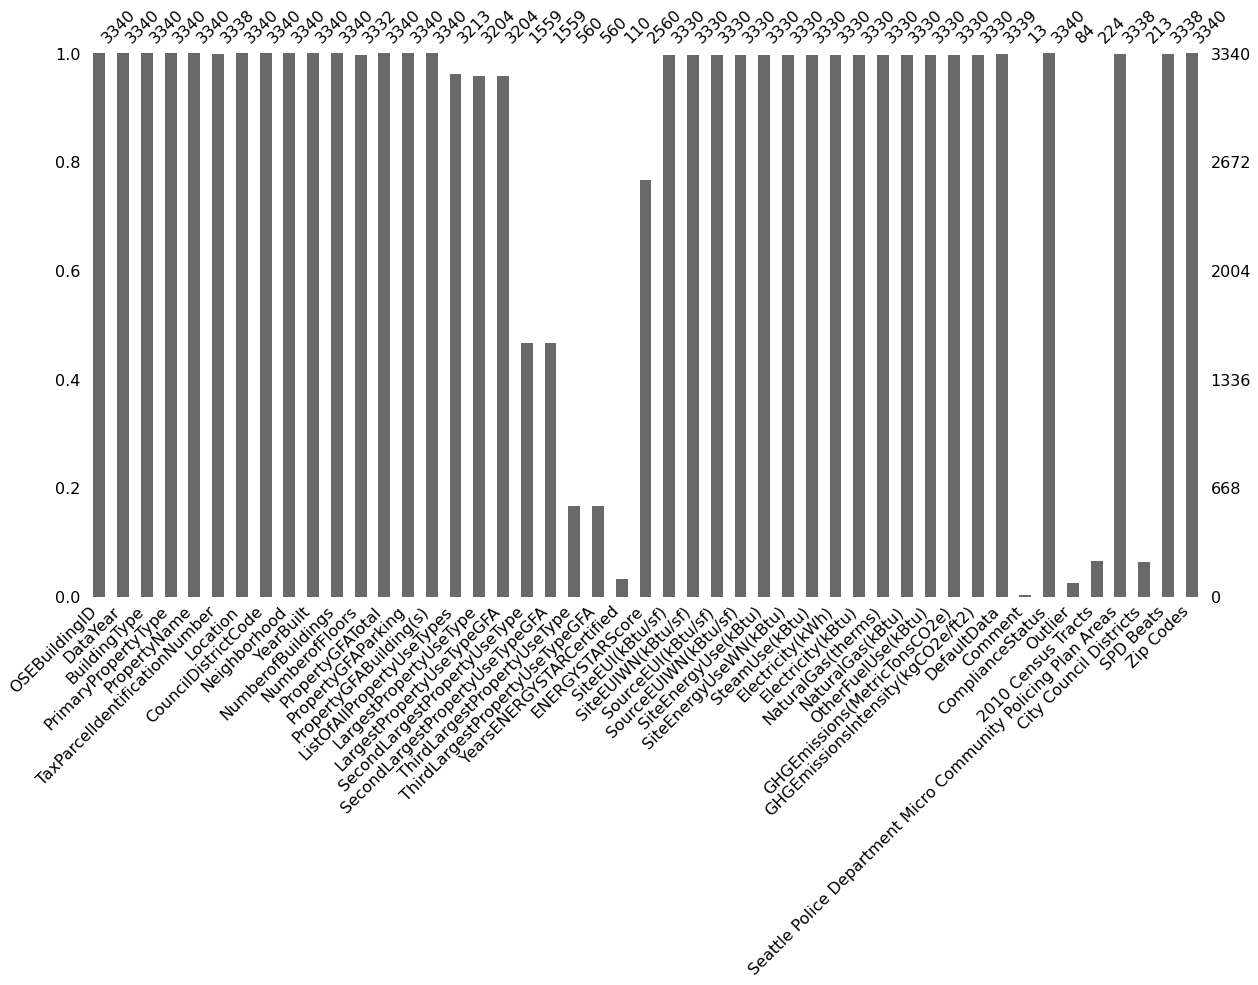

In [10]:
# donnees 2015
msno.bar(df_2015, figsize=(20,10))

<AxesSubplot:>

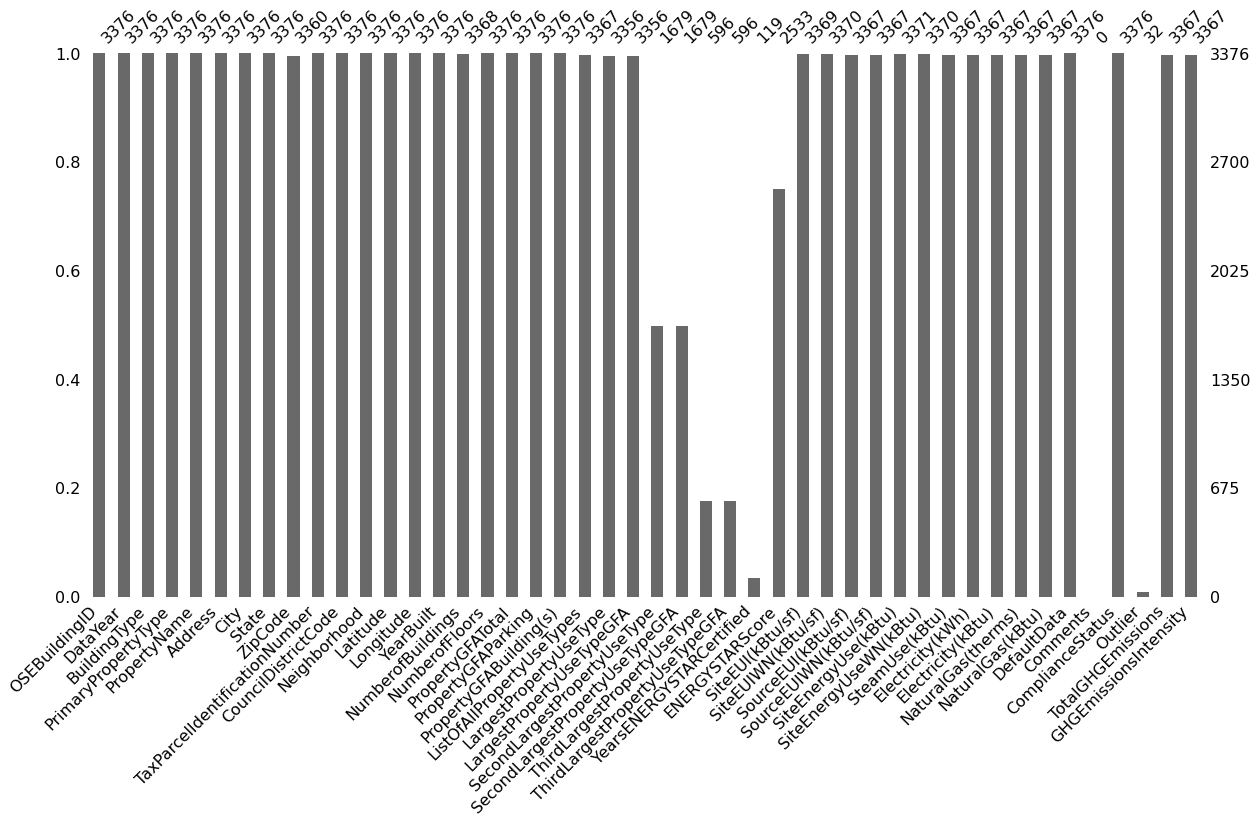

In [11]:
# donnees 2016
msno.bar(df_2016, figsize=(20,10))

In [8]:
df_2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   OSEBuildingID                                                  3340 non-null   int64  
 1   DataYear                                                       3340 non-null   int64  
 2   BuildingType                                                   3340 non-null   object 
 3   PrimaryPropertyType                                            3340 non-null   object 
 4   PropertyName                                                   3340 non-null   object 
 5   TaxParcelIdentificationNumber                                  3338 non-null   object 
 6   Location                                                       3340 non-null   object 
 7   CouncilDistrictCode                                         

In [12]:
df_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

### On remarque que les colonnes ne sont pas identiques dans les 2 fichiers 2015 et 2016. 

## <font color="blue" id="section_3"> C- Concaténation des données de 2015 et 2016

### Comparaison des colonnes des 2 dataframes (df_2015 et df_2016)

In [13]:
compar_col(df_2015,df_2016, 'df_2015', 'df_2016')

Variables différentes dans df_2015 : ['Location', 'OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)', 'Comment', '2010 Census Tracts', 'Seattle Police Department Micro Community Policing Plan Areas', 'City Council Districts', 'SPD Beats', 'Zip Codes'] 

 Variables différentes dans df_2016 : ['Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude', 'Comments', 'TotalGHGEmissions', 'GHGEmissionsIntensity'] 


#### On remarque qu'il y a pour certaines varibales juste une différence de caractères comme 'ZipCode' et 'Zip Codes' qui ont le meme format sauf que 'Zip Codes' dans df_2015 correspond aux boites postales et 'ZipCode' dans df_2016 correspond au code postale. 'Comments' et 'Comment' sont les memes mais quasi vide (13 et 0) donc à supprimer. Pour,('GHGEmissionsIntensity(kgCO2e/ft2)//GHGEmissionsIntensity') et  ('TotalGHGEmissions'//'GHGEmissions(MetricTonsCO2e)' ), il y a  l'ajout d'unités. Il  faut vérifier qu'ils sont dans les memes unités. Pour le reste à vérifier leur importance pour voir on garde lesquelles.


In [14]:
display(disp_col_sample(df_2016, ['DataYear', 'ZipCode'], 5) )
print('--------------------------------------------')
display(disp_col_sample(df_2015, ['DataYear','Zip Codes'], 5))

,DataYear,ZipCode
222,2016,98104.0
1986,2016,98115.0
2888,2016,98116.0
876,2016,98101.0
546,2016,98103.0


--------------------------------------------


,DataYear,Zip Codes
2039,2015,18385
1497,2015,19575
3327,2015,18383
3106,2015,19581
2364,2015,18376


## Variable Location dans 2015

In [15]:
disp_col_sample(df_2015, ['Location', 'Zip Codes'], 3)


,Location,Zip Codes
1525,"{'latitude': '47.70716999', 'longitude': '-122.2846645', 'human_address': '{""address"": ""4030 NE 109TH ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98125""}'}",19579
1564,"{'latitude': '47.55952254', 'longitude': '-122.3838375', 'human_address': '{""address"": ""4752 41ST AVE SW"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98116""}'}",18795
943,"{'latitude': '47.65873718', 'longitude': '-122.31400299', 'human_address': '{""address"": ""4210 BROOKLYN AVE NE"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98105""}'}",18383


Dans la variable Location il y a 2 dictionnaires : le premier contient [latitude, longitude] et le second qui a une clé (human_adress=adresse complet) dans le premier, contient [street, city, state, zip] c'est le zip dans l'adresse qui correspond au variable 'ZipCode' dans df_2016. Extraire toutes les variables dans location à part et séparer ces variables pour extraire les variables imbriquées.

 ### Extraire toutes les variables inclues dans la variable location 2015 

In [16]:
df_2015_c=  df_2015.copy()
df_2016_c=  df_2016.copy()
# literal_eval will evaluate the string that contains a dictionary here and get it 
df_loc=df_2015_c['Location'].map(literal_eval).apply(pd.Series)
df_adress=df_loc['human_address'].map(literal_eval).apply(pd.Series)

In [17]:
df_loc.head(4)

,latitude,longitude,human_address
0,47.61219025,-122.33799744,"{""address"": ""405 OLIVE WAY"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}"
1,47.61310583,-122.33335756,"{""address"": ""724 PINE ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}"
2,47.61334897,-122.33769944,"{""address"": ""1900 5TH AVE"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}"
3,47.61421585,-122.33660889,"{""address"": ""620 STEWART ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}"


In [18]:
df_adress.head(4)

,address,city,state,zip
0,405 OLIVE WAY,SEATTLE,WA,98101
1,724 PINE ST,SEATTLE,WA,98101
2,1900 5TH AVE,SEATTLE,WA,98101
3,620 STEWART ST,SEATTLE,WA,98101


In [19]:
df_2015_c=pd.concat([df_2015_c, df_loc, df_adress], axis=1 )

In [20]:
df_2015_c.drop(['Location','human_address' ], axis=1, inplace=True)

In [21]:
# renommer les colonnes selon la nomination dans df_2016 

df_2015_c = df_2015_c.rename(columns={"latitude": "Latitude","longitude": "Longitude","address": "Address","city": "City","state": "State", "zip": "ZipCode"})

In [22]:
# Comparer a nouveau les colonnes des 2 dataframes 

compar_col(df_2015_c,df_2016, 'df_2015', 'df_2016')

Variables différentes dans df_2015 : ['OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)', 'Comment', '2010 Census Tracts', 'Seattle Police Department Micro Community Policing Plan Areas', 'City Council Districts', 'SPD Beats', 'Zip Codes'] 

 Variables différentes dans df_2016 : ['Comments', 'TotalGHGEmissions', 'GHGEmissionsIntensity'] 


#### Verifions si ['GHGEmissionsIntensity' et  'GHGEmissionsIntensity(kgCO2e/ft2)'] sont en meme unites de meme pour ['GHGEmissions(MetricTonsCO2e)' et 'TotalGHGEmissions']

In [23]:
print(pd.concat([df_2015['GHGEmissions(MetricTonsCO2e)'].describe(),  df_2016['TotalGHGEmissions'].describe()], axis=1))
print('----------------------------------------------------------------------------------------------')
print(pd.concat([df_2015['GHGEmissionsIntensity(kgCO2e/ft2)'].describe(),  df_2016['GHGEmissionsIntensity'].describe()], axis=1))

       GHGEmissions(MetricTonsCO2e)  TotalGHGEmissions
count                   3330.000000        3367.000000
mean                     110.094102         119.723971
std                      409.450179         538.832227
min                        0.000000          -0.800000
25%                        9.265000           9.495000
50%                       32.740000          33.920000
75%                       88.642500          93.940000
max                    11824.890000       16870.980000
----------------------------------------------------------------------------------------------
       GHGEmissionsIntensity(kgCO2e/ft2)  GHGEmissionsIntensity
count                        3330.000000            3367.000000
mean                            0.985339               1.175916
std                             1.637172               1.821452
min                             0.000000              -0.020000
25%                             0.080000               0.210000
50%                       

Elles sont du meme ordre de grandeurs donc en meme unites. Renommer-les a l'identique

In [24]:
df_2015_c = df_2015_c.rename(columns={'GHGEmissions(MetricTonsCO2e)':'TotalGHGEmissions',
                                  'GHGEmissionsIntensity(kgCO2e/ft2)':'GHGEmissionsIntensity', 'Comment':'Comments' })
                                 

In [25]:
compar_col(df_2015_c,df_2016_c, 'df_2015', 'df_2016')

Variables différentes dans df_2015 : ['OtherFuelUse(kBtu)', '2010 Census Tracts', 'Seattle Police Department Micro Community Policing Plan Areas', 'City Council Districts', 'SPD Beats', 'Zip Codes'] 

 Variables différentes dans df_2016 : [] 


#### Examinons les autres variables qui ne sont pas dans df_2016 si elles sont utiles pour la suite pour decider de les suppprimer ou de les garder

In [28]:
df_2015_c.loc[df_2015_c['OtherFuelUse(kBtu)']!=0]['OtherFuelUse(kBtu)'].count()

17

In [29]:
# secteur de recensement to delete car peu d'informations seulement 224
df_2015_c.loc[df_2015_c['2010 Census Tracts']!=0]['2010 Census Tracts'].count()

224

City Council Districts (213)  to delete    
zip codes= boite postal to delete    
'OtherFuelUse(kBtu)' 17 #0 to delete    
2010 Census Tracts  224 seulement to delete    
SPD Beats (Seattle Police Department) territoire ou la police patrouille ca doit etre commme Seattle Police Department   Micro Community Policing Plan Area mais ne correspond pas aux meme chiffre je supprime les 2 

In [30]:
to_drop = ['OtherFuelUse(kBtu)','Comments','2010 Census Tracts','Seattle Police Department Micro Community Policing Plan Areas','City Council Districts', 'SPD Beats', 'Zip Codes']
df_2015_c = df_2015_c.drop(to_drop, axis=1)
df_2016_c = df_2016_c.drop(['Comments'], axis=1)

In [31]:
compar_col(df_2015_c,df_2016_c, 'df_2015', 'df_2016')

Variables différentes dans df_2015 : [] 

 Variables différentes dans df_2016 : [] 


### Concaténation des 2 dataframes

In [ ]:
df_tot = pd.concat([df_2015_c,df_2016_c])
print(df_tot.shape)
# sauvegarde du dataframe total
df_tot.to_csv('df_tot.csv', index=False)

In [33]:
df_tot.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,DefaultData,ComplianceStatus,Outlier,Latitude,Longitude,Address,City,State,ZipCode
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1.0,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,249.43,2.64,No,Compliant,NaN,47.612190,-122.337997,405 OLIVE WAY,SEATTLE,WA,98101.0
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,7,DOWNTOWN,1996,1.0,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,263.51,2.38,No,Compliant,NaN,47.613106,-122.333358,724 PINE ST,SEATTLE,WA,98101.0
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,7,DOWNTOWN,1969,1.0,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,NaN,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,37099.0,3709900.0,2061.48,1.92,Yes,Compliant,NaN,47.613349,-122.337699,1900 5TH AVE,SEATTLE,WA,98101.0
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,7,DOWNTOWN,1926,1.0,10.0,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,1.0,460.4,462.5,636.3,643.2,28229320.0,28363444.0,23458518.0,811521.0,2769023.0,20019.0,2001894.0,1936.34,31.38,No,Compliant,High Outlier,47.614216,-122.336609,620 STEWART ST,SEATTLE,WA,98101.0
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,7,DOWNTOWN,1980,1.0,18.0,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,67.0,120.1,122.1,228.8,227.1,14829099.0,15078243.0,0.0,1777841.0,6066245.0,87631.0,8763105.0,507.70,4.02,No,Compliant,NaN,47.613754,-122.340924,401 LENORA ST,SEATTLE,WA,98121.0


In [34]:
print(len(list(df_tot.select_dtypes(include='object').columns)))

print(len(list(df_tot.select_dtypes(include=['int64','float64']).columns)))

16
29


Au total, on a 29 variables numeriques et 16 objets

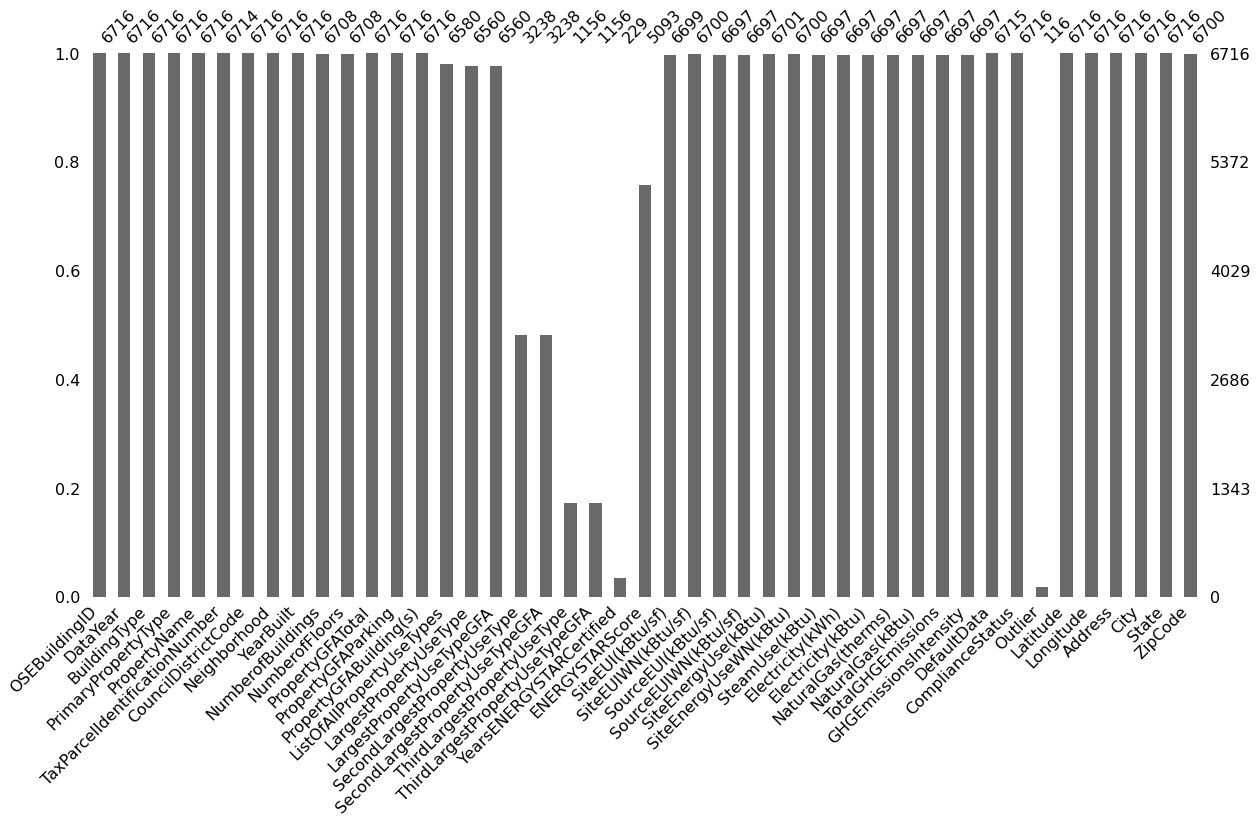

In [35]:
plt.clf()
plt.close()
msno.bar(df_tot, figsize=(20,10))
plt.savefig('msno tot', dpi=200, bbox_inches='tight') 
plt.show()


##  <font color="blue" id="section_4"> D- Nettoyage des données et selection des variables pertinentes
    


In [36]:
df_tot.shape

(6716, 45)

In [37]:
df_tot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6716 entries, 0 to 6715
Data columns (total 45 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    6716 non-null   int64  
 1   DataYear                         6716 non-null   int64  
 2   BuildingType                     6716 non-null   object 
 3   PrimaryPropertyType              6716 non-null   object 
 4   PropertyName                     6716 non-null   object 
 5   TaxParcelIdentificationNumber    6714 non-null   object 
 6   CouncilDistrictCode              6716 non-null   int64  
 7   Neighborhood                     6716 non-null   object 
 8   YearBuilt                        6716 non-null   int64  
 9   NumberofBuildings                6708 non-null   float64
 10  NumberofFloors                   6708 non-null   float64
 11  PropertyGFATotal                 6716 non-null   int64  
 12  PropertyGFAParking  

Inspectons les variables pour comprendre leur utilité dans le projet : 

- Plusieurs variables concernent les surfaces (GFA = Gross floor area) :

PropertyGFATotal   : surface totale  
PropertyGFAParking : surface des parkings  
PropertyGFABuilding(s) : surface des bâtiments    
ListOfAllPropertyUseTypes : les différentes utilisations des surfaces (Hotel, Parking, Restaurant, etc.)  
LargestPropertyUseType / LargestPropertyUseTypeGFA : principale destination du bâtiment et sa surface    
SecondLargestPropertyUseType / SecondLargestPropertyUseTypeGFA : seconde destination du bâtiment et sa surface    
ThirdLargestPropertyUseType / ThirdLargestPropertyUseTypeGFA : troisième destination du bâtiment et sa surface    

Pour l'énergie, ENERGY STAR nous indique :

- YearsENERGYSTARCertified :l'année d'attribution du certificat energystar. très mal renseigné seulement 188 et pas utile --> <font color ='red'> a supprimer

- SiteEUI(kBtu/sf) / SiteEUIWN(kBtu/sf) : Energy Use Intensity (EUI) ou intensité de la consommation d'énergie exprime la consommation d'énergie d'un bâtiment en fonction de sa taille ou d'autres caractéristiques. (exprimé en kilo British thermal units per square foot per year: équivaut à 1055,06 Joule ou 252 calories.
Site energy: est la quantite d'electricite consommee telle exprimee sur la facture d'electricite.
WN : pour Weather Normalised: l'energie est normalise par rapport au conditions meteo. 
- SourceEUI(kBtu/sf)-SourceEUIWN(kBtu/sf) : la source d'énergie est l'unité d'évaluation la plus équitable pour comparer différents bâtiments entre eux. La source d'énergie représente la quantité totale de combustible brut nécessaire au fonctionnement du bâtiment. Il intègre toutes les pertes de transmission, de livraison et de production. En prenant en compte toutes les consommations d'énergie, le score fournit une évaluation complète de l'efficacité énergétique d'un bâtiment. c'est la source qui est utilisé dans le calcul du ENERGYSTARScore. 
- NaturalGas(therms) et	NaturalGas(kBtu) therms : le therm est une unité d'énergie thermique anglo-saxone égale à 100,000 unités thermiques britanniques (BTU) <font color='red'> A suprimer un des 2
- Electricity(kWh)	Electricity(kBtu):  1 kWh équivaut à 3415 BTU/h  donc on a la meme variable dans differentes unités. <font color='red'> A suprimer un des 2 
    
- ENERGYSTARScore : score attribué selon la consommation et qu'on doit étudier son utilité dans les predictions    
    
-   SiteEnergyUse(kBtu) L'energie totale consommee durant un an par une propriete toute source inclue (electricite, fuel, vapeur, etc) <font color ='red'> C'est la variable a predire

- TotalGHGEmissions	Emission annuelle totale de gaz a effet de serre d'une propriete <font color ='red'> (variable a predire)   
    
Autres variables:
- Outlier : seulement  48 renseignes <font color ='red'> Supprimer ces outliers ensuite supprimer la variable
- ComplianceStatus : etat de conformite bien renseignee.  <font color ='red'> supprimer données non conformes ensuite supprimer la variable


### Supprimer les colonnes redondantes ou non pertinentes  


In [38]:
df_tot_filt=df_tot.copy()

In [39]:
#Supprimer les variables redondantes avec des unites differentes : ( NaturalGas(therms) et (NaturalGas(kBtu) )  ( Electricity(kWh) et (Electricity(kBtu) ) 
to_drop = ['NaturalGas(therms)','Electricity(kWh)']
df_tot_filt.drop(to_drop, axis=1, inplace=True)

In [40]:
#Supprimer les variables normalisees selon conditions climatiques cad qui contient WN 
df_tot_filt.drop(search_suffix(df_tot_filt,'WN'), axis=1, inplace=True)

Supprimer la variable 'outlier' car très peu renseigné mais avant on va supprimer les lignes correspondant à ces outliers

In [41]:
mask=(df_tot_filt["Outlier"].notnull())
df_tot_filt = df_tot_filt[~mask]

In [42]:
df_tot_filt.drop('Outlier', axis=1, inplace=True)

Supprimer  la variable 'ComplianceStatus'  après avoir supprimé les données non conformes

In [43]:
 df_tot_filt['ComplianceStatus'].unique()

array(['Compliant', 'Not Compliant', 'Error - Correct Default Data',
       'Missing Data', 'Non-Compliant'], dtype=object)

In [44]:
# drop donnees qui ne sont pas conformes selon compliancestatus
df_tot_filt = df_tot_filt[df_tot_filt['ComplianceStatus'] == "Compliant"]

In [45]:
df_tot_filt.shape

(6464, 39)

Supprimer les variables sans interets  DefaultData,  YearsENERGYSTARCertified (seulement 188 valeurs), City, state (valeur unique Seattle)

In [46]:
#Supprimer YearsENERGYSTARCertified très mal renseigné (188 valeurs) et pas util
df_tot_filt.drop(['YearsENERGYSTARCertified','State', 'City', 'ComplianceStatus','DefaultData'], axis=1, inplace=True)

#### Dans le projet, il est précisé qu'on s’intéresse aux émissions des bâtiments non destinés à l’habitation alors on supprime les données qui correspondent à des habitations en se basant sur la variable BuildingType

In [47]:
df_tot_filt['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Multifamily LR (1-4)', 'Campus',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

On présume que les building labelé multifamily sont des habitations. On les supprime

In [48]:
df_tot_filt = df_tot_filt[~df_tot_filt['BuildingType'].str.contains("Multifamily")]

In [49]:
df_tot_filt.shape

(3167, 34)

### Doublons sur les ID des bâtiments 

In [50]:
df_tot_filt.sort_values(by='OSEBuildingID').head(6)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Latitude,Longitude,Address,ZipCode
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1.0,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,65.0,78.900000,173.500000,6981428.0,2023032.0,3686160.0,1272388.0,249.43,2.64,47.612190,-122.337997,405 OLIVE WAY,98101.0
3340,1,2016,NonResidential,Hotel,Mayflower park hotel,0659000030,7,DOWNTOWN,1927,1.0,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,60.0,81.699997,182.500000,7226362.5,2003882.0,3946027.0,1276453.0,249.98,2.83,47.612200,-122.337990,405 Olive way,98101.0
3341,2,2016,NonResidential,Hotel,Paramount Hotel,0659000220,7,DOWNTOWN,1996,1.0,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,94.800003,176.100006,8387933.0,0.0,3242851.0,5145082.0,295.86,2.86,47.613170,-122.333930,724 Pine street,98101.0
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,7,DOWNTOWN,1996,1.0,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,51.0,94.400000,191.300000,8354235.0,0.0,3905411.0,4448985.0,263.51,2.38,47.613106,-122.333358,724 PINE ST,98101.0
3342,3,2016,NonResidential,Hotel,5673-The Westin Seattle,0659000475,7,DOWNTOWN,1969,1.0,41.0,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,43.0,96.000000,241.899994,72587024.0,21566554.0,49526664.0,1493800.0,2089.28,2.19,47.613930,-122.338100,1900 5th Avenue,98101.0
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,7,DOWNTOWN,1969,1.0,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,18.0,96.600000,242.700000,73130656.0,19660404.0,49762435.0,3709900.0,2061.48,1.92,47.613349,-122.337699,1900 5TH AVE,98101.0


In [51]:
# les doublons des batiments avec la cosommation totale d'energie et l'émission totale des gaz
cols = ['OSEBuildingID','DataYear','SiteEnergyUse(kBtu)','TotalGHGEmissions']
duplicat_build = df_tot_filt[cols].groupby("OSEBuildingID").filter(lambda x: len(x) > 1).sort_values(by='OSEBuildingID')
duplicat_build

,OSEBuildingID,DataYear,SiteEnergyUse(kBtu),TotalGHGEmissions
0,1,2015,6.981428e+06,249.43
3340,1,2016,7.226362e+06,249.98
3341,2,2016,8.387933e+06,295.86
1,2,2015,8.354235e+06,263.51
2,3,2015,7.313066e+07,2061.48
...,...,...,...,...
3319,49998,2015,8.505680e+05,12.40
6634,50002,2016,1.399582e+06,9.76
3322,50002,2015,1.389553e+06,9.69
3334,50038,2015,6.286090e+05,4.38


In [52]:
non_duplicat_build = df_tot_filt[cols].groupby("OSEBuildingID").filter(lambda x: len(x) ==1).sort_values(by='OSEBuildingID')
non_duplicat_build 

,OSEBuildingID,DataYear,SiteEnergyUse(kBtu),TotalGHGEmissions
3343,5,2016,6.794584e+06,286.43
22,28,2015,1.454222e+06,35.17
28,34,2015,6.283226e+06,244.51
30,36,2015,6.387710e+06,260.37
31,37,2015,1.472548e+06,10.27
...,...,...,...,...
6710,50221,2016,9.320821e+05,20.33
6712,50223,2016,9.502762e+05,32.17
6713,50224,2016,5.765898e+06,223.54
6714,50225,2016,7.194712e+05,22.11


Nous avos 201 batiments présents une seule fois dans le dataframe total!

In [53]:
perc_ecart = duplicat_build.groupby('OSEBuildingID')['SiteEnergyUse(kBtu)'].agg(['max','min'])

In [54]:
perc_ecart['ecart'] = ((perc_ecart['max']-perc_ecart['min'])/perc_ecart['max'])*100
perc_ecart.head()

,max,min,ecart
OSEBuildingID,,,
1,7226362.5,6981428.0,3.389458
2,8387933.0,8354235.0,0.401744
3,73130656.0,72587024.0,0.743371
8,14829099.0,14172606.0,4.427059
9,12086616.0,12051984.0,0.286532


Text(0.5, 6.800000000000011, 'Ecart de consommation énergétique 2015/2016 (en %)')

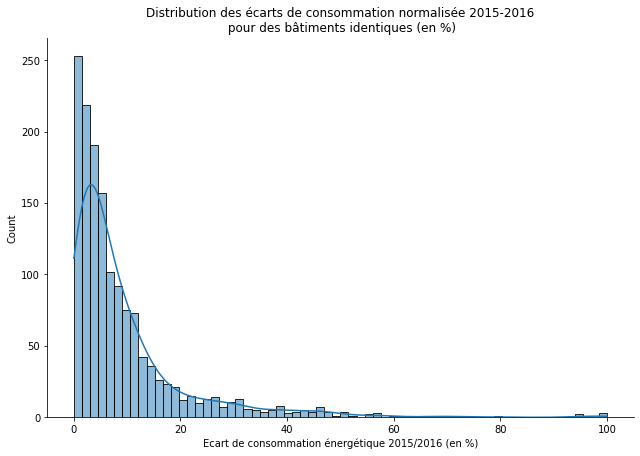

In [57]:
g=sns.displot(perc_ecart['ecart'], kde=True, palette='bright', legend=False, height=6, aspect=1.5)
g.set(title='Distribution des écarts de consommation normalisée 2015-2016\n pour des bâtiments identiques (en %)')
plt.xlabel('Ecart de consommation énergétique 2015/2016 (en %)')

Selon la distribution, peu de batiments avec un pourcentage d'écart important entre 2015 et 2016. Les écarts 100% correspondent à des relevés nulles d'énergie! (2 valeurs à supprimer ultérieurment). Regardons de plus près les données dont l'écart est supérieur à la moyenne + 3 x la déviation standard

In [58]:
seuil_outlier=(perc_ecart['ecart'].mean())+(3*perc_ecart['ecart'].std()) 
seuil_outlier

44.93520980135772

In [59]:
gd_ecart = perc_ecart.loc[perc_ecart['ecart']>(seuil_outlier)].index
gd_ecart.shape

(35,)

In [60]:
df_gd_ecart = df_tot_filt[df_tot_filt['OSEBuildingID'].isin(gd_ecart)].sort_values(by='OSEBuildingID')
df_gd_ecart

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Latitude,Longitude,Address,ZipCode
44,58,2015,NonResidential,Retail Store,CENTURY SQUARE RETAIL,1975700365,7,DOWNTOWN,1920,1.0,2.0,57428,0,57428,"Non-Refrigerated Warehouse, Other, Retail Store",Retail Store,34617.0,Non-Refrigerated Warehouse,13028.0,Other,9783.0,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,47.610764,-122.337677,1525 4TH AVE,98101.0
3385,58,2016,NonResidential,Other,1525 4th Avenue,1975700365,7,DOWNTOWN,1920,1.0,2.0,57428,0,57428,"Other - Mall, Personal Services (Health/Beauty, Dry Cleaning, etc)",Other - Mall,51747.0,"Personal Services (Health/Beauty, Dry Cleaning, etc)",5681.0,NaN,NaN,NaN,21.700001,48.799999,1247362.0,0.0,714939.0,532423.0,33.26,0.58,47.610760,-122.337650,1525 4th Ave,98101.0
233,355,2015,NonResidential,Large Office,901 FIFTH AVENUE,942000365,7,DOWNTOWN,1973,1.0,42.0,617684,171500,446184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.0,62.500000,187.600000,37527176.0,2668771.0,34859838.0,0.0,449.01,0.48,47.606056,-122.331788,901 5TH AVE,98104.0
3571,355,2016,NonResidential,Large Office,901 Fifth Avenue,0942000365,7,DOWNTOWN,1973,1.0,42.0,617684,171500,446184,"Financial Office, Office, Parking, Retail Store",Office,581558.0,Parking,189600.0,Retail Store,18026.0,28.0,115.900002,361.200012,69519808.0,882983.5,68636822.0,0.0,546.65,0.88,47.606160,-122.331650,901 Fifth Avenue,98164.0
389,543,2015,NonResidential,Distribution Center\n,SEATTLE DISTRIBUTION CENTER BLDG 1,5367204080,2,GREATER DUWAMISH,1967,1.0,1.0,124472,0,124472,"Distribution Center, Parking",Distribution Center,124423.0,Parking,0.0,NaN,NaN,92.0,19.700000,32.900000,2457017.0,0.0,725614.0,1731432.0,97.01,0.75,47.542186,-122.329036,6701 E MARGINAL WAY S,98108.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3155,34348,2015,NonResidential,Retail Store,PIKE PLAZA - TARGET STORE,6065010000,7,DOWNTOWN,1991,1.0,3.0,103000,0,103000,Retail Store,Retail Store,103000.0,NaN,NaN,NaN,NaN,100.0,21.500000,57.600000,2218249.0,0.0,1723361.0,494960.0,38.30,0.30,47.608648,-122.338789,1401 2ND AVE,98101.0
6474,40348,2016,NonResidential,Mixed Use Property,Broadway Market,6850700316 and 6850700315,3,EAST,1916,1.0,2.0,140823,59401,81422,"Multifamily Housing, Parking, Personal Services (Health/Beauty, Dry Cleaning, etc), Retail Store, Supermarket/Grocery Store",Parking,89820.0,Supermarket/Grocery Store,64000.0,Multifamily Housing,41014.0,NaN,19.700001,58.799999,2762846.0,0.0,2554939.0,207907.0,28.85,0.20,47.622560,-122.320920,401 Broadway E,98102.0
3175,40348,2015,NonResidential,Retail Store,BROADWAY MARKET AND HARVARD APTS,6850700316 and 6850700315,3,EAST,1916,1.0,2.0,140823,59401,81422,Retail Store,Retail Store,157610.0,NaN,NaN,NaN,NaN,30.0,86.200000,267.200000,13586070.0,0.0,13325914.0,260710.0,106.74,0.35,47.622117,-122.320999,401 BROADWAY E,98102.0
3305,49940,2015,NonResidential,Hospital,VIRGINIA MASON- CENTRAL PAVILLION,1979200210,3,EAST,1920,1.0,8.0,374466,0,374466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,210.000000,413.100000,78652064.0,47648276.0,31005073.0,0.0,3894.01,10.04,47.609840,-122.327441,925 SENECA ST,98101.0


#### Pour certains batiments, il y a eu un changement d'utilisation du batiment entre 2015 et 2016 comme par exemple building (40348) qui peut expliquer une augmentation importante de consommation d'énergie. Voyons s'il y en a d'autres batiments dans ce cas :

In [61]:
grouped = df_gd_ecart.groupby(['OSEBuildingID', 'PrimaryPropertyType'])

new_list=[key for key,value in grouped.groups]

use_change=listToSet(new_list)

df_gd_ecart.loc[df_gd_ecart['OSEBuildingID'].isin(use_change)].head(6)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Latitude,Longitude,Address,ZipCode
44,58,2015,NonResidential,Retail Store,CENTURY SQUARE RETAIL,1975700365,7,DOWNTOWN,1920,1.0,2.0,57428,0,57428,"Non-Refrigerated Warehouse, Other, Retail Store",Retail Store,34617.0,Non-Refrigerated Warehouse,13028.0,Other,9783.0,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,47.610764,-122.337677,1525 4TH AVE,98101.0
3385,58,2016,NonResidential,Other,1525 4th Avenue,1975700365,7,DOWNTOWN,1920,1.0,2.0,57428,0,57428,"Other - Mall, Personal Services (Health/Beauty, Dry Cleaning, etc)",Other - Mall,51747.0,"Personal Services (Health/Beauty, Dry Cleaning, etc)",5681.0,NaN,NaN,NaN,21.700001,48.799999,1247362.0,0.0,714939.0,532423.0,33.26,0.58,47.610760,-122.337650,1525 4th Ave,98101.0
389,543,2015,NonResidential,Distribution Center\n,SEATTLE DISTRIBUTION CENTER BLDG 1,5367204080,2,GREATER DUWAMISH,1967,1.0,1.0,124472,0,124472,"Distribution Center, Parking",Distribution Center,124423.0,Parking,0.0,NaN,NaN,92.0,19.700000,32.900000,2457017.0,0.0,725614.0,1731432.0,97.01,0.75,47.542186,-122.329036,6701 E MARGINAL WAY S,98108.0
3726,543,2016,NonResidential,Distribution Center,Seattle Distribution Center Bldg A,5367204080,2,GREATER DUWAMISH,1967,1.0,1.0,124472,0,124472,"Distribution Center, Parking",Distribution Center,124423.0,Parking,0.0,NaN,NaN,62.0,43.900002,65.400002,5464762.0,0.0,1145957.0,4318805.0,237.36,1.91,47.541870,-122.327140,6701-6795 E. Marginal Way S.,98168.0
3803,624,2016,NonResidential,Other,South Occidental Warehouse,7666206115,2,GREATER DUWAMISH,1941,2.0,2.0,125519,0,125519,Manufacturing/Industrial Plant,Manufacturing/Industrial Plant,142901.0,NaN,NaN,NaN,NaN,NaN,15.700000,49.299999,2244317.0,0.0,2244317.0,0.0,15.65,0.12,47.584440,-122.332820,1900 Occidental Ave S,98134.0
465,624,2015,NonResidential,Non-Refrigerated Warehouse,OCCIDENTAL WAREHOUSE,7666206115,2,GREATER DUWAMISH,1941,1.0,2.0,125519,0,125519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.900000,75.600000,4999863.0,0.0,2666590.0,2333384.0,142.52,1.04,47.584385,-122.332805,1900 OCCIDENTAL AVE S,98134.0


Corriger les données avec \n 

In [63]:
df_gd_ecart['PrimaryPropertyType'] = df_gd_ecart['PrimaryPropertyType'].str.replace('\n','')

In [64]:
grouped = df_gd_ecart.groupby(['OSEBuildingID', 'PrimaryPropertyType'])
new_list=[key for key,value in grouped.groups]
use_change=listToSet(new_list)
use_change_true=df_gd_ecart.loc[df_gd_ecart['OSEBuildingID'].isin(use_change)]



Il s'agit bien de changement d'utilisation de ces batiments. Pour le reste :

In [65]:
use_change_other=df_gd_ecart.loc[~(df_gd_ecart['OSEBuildingID'].isin(use_change))]
use_change_other

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Latitude,Longitude,Address,ZipCode
233,355,2015,NonResidential,Large Office,901 FIFTH AVENUE,942000365,7,DOWNTOWN,1973,1.0,42.0,617684,171500,446184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.0,62.500000,187.600000,3.752718e+07,2668771.0,34859838.0,0.0,449.01,0.48,47.606056,-122.331788,901 5TH AVE,98104.0
3571,355,2016,NonResidential,Large Office,901 Fifth Avenue,0942000365,7,DOWNTOWN,1973,1.0,42.0,617684,171500,446184,"Financial Office, Office, Parking, Retail Store",Office,581558.0,Parking,189600.0,Retail Store,18026.0,28.0,115.900002,361.200012,6.951981e+07,882983.5,68636822.0,0.0,546.65,0.88,47.606160,-122.331650,901 Fifth Avenue,98164.0
389,543,2015,NonResidential,Distribution Center,SEATTLE DISTRIBUTION CENTER BLDG 1,5367204080,2,GREATER DUWAMISH,1967,1.0,1.0,124472,0,124472,"Distribution Center, Parking",Distribution Center,124423.0,Parking,0.0,NaN,NaN,92.0,19.700000,32.900000,2.457017e+06,0.0,725614.0,1731432.0,97.01,0.75,47.542186,-122.329036,6701 E MARGINAL WAY S,98108.0
3726,543,2016,NonResidential,Distribution Center,Seattle Distribution Center Bldg A,5367204080,2,GREATER DUWAMISH,1967,1.0,1.0,124472,0,124472,"Distribution Center, Parking",Distribution Center,124423.0,Parking,0.0,NaN,NaN,62.0,43.900002,65.400002,5.464762e+06,0.0,1145957.0,4318805.0,237.36,1.91,47.541870,-122.327140,6701-6795 E. Marginal Way S.,98168.0
425,580,2015,NonResidential,Large Office,PEMCO,3025049001,7,MAGNOLIA / QUEEN ANNE,1986,1.0,5.0,154029,62380,91649,"Office, Parking",Office,91645.0,Parking,66288.0,NaN,NaN,NaN,20.600000,47.500000,1.886382e+06,0.0,1134608.0,751821.0,47.84,0.28,47.631082,-122.341911,1300 DEXTER AVE N,98109.0
3761,580,2016,NonResidential,Large Office,PEMCO,3025049001,7,MAGNOLIA / QUEEN ANNE,1986,1.0,5.0,154029,62380,91649,"Office, Parking",Office,91645.0,Parking,66288.0,NaN,NaN,95.0,50.599998,145.699997,4.636396e+06,0.0,4060681.0,575715.0,58.88,0.38,47.631160,-122.341930,1300 Dexter Ave N,98109.0
550,740,2015,NonResidential,Small- and Mid-Sized Office,THE CANAL VIEW BUILDING,1972206514,6,LAKE UNION,2000,1.0,2.0,77174,25800,51374,Office,Office,77174.0,NaN,NaN,NaN,NaN,1.0,164.600000,484.800000,1.270401e+07,0.0,11518186.0,1186306.0,143.30,1.21,47.649292,-122.351929,551 N 34TH ST,98103.0
3887,740,2016,NonResidential,Small- and Mid-Sized Office,The Canal View Building,1972206514,6,LAKE UNION,2000,1.0,2.0,77174,25800,51374,Office,Office,77174.0,NaN,NaN,NaN,NaN,33.0,71.000000,223.000000,5.481549e+06,0.0,5481548.0,0.0,38.21,0.50,47.649320,-122.351870,551 N 34th St,98103.0
3911,765,2016,NonResidential,Large Office,Seattle Tower,1975200005,7,DOWNTOWN,1929,1.0,27.0,216571,13320,203251,"Office, Other - Technology/Science, Parking",Office,182604.0,Parking,13320.0,Other - Technology/Science,6246.0,62.0,86.000000,192.699997,1.624611e+07,7413886.0,8704772.0,127447.0,639.72,2.95,47.607690,-122.335440,1218 3rd Avenue,98101.0
572,765,2015,NonResidential,Large Office,SEATTLE TOWER,1975200005,7,DOWNTOWN,1929,1.0,27.0,216571,13320,203251,"Office, Other - Technology/Science, Parking",Office,182604.0,Parking,13320.0,Other - Technology/Science,6246.0,NaN,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.00,0.00,47.607655,-122.335512,1218 3RD AVE,98101.0


In [66]:
# pourcentage d'écart inexpliqué (pas de changement d'utilisation des batiments)
perc_ecart_inexp=perc_ecart.loc[perc_ecart.index.isin(use_change_other['OSEBuildingID'])].sort_values(by='ecart',ascending=False)
perc_ecart_inexp

,max,min,ecart
OSEBuildingID,,,
765,1.624611e+07,0.000000e+00,100.000000
24205,6.129780e+06,2.932170e+05,95.216517
803,3.795171e+07,2.019254e+06,94.679412
24591,3.087318e+06,9.035419e+05,70.733761
21945,2.323265e+06,7.293972e+05,68.604650
20402,2.735166e+06,1.024033e+06,62.560481
580,4.636396e+06,1.886382e+06,59.313618
34348,5.214622e+06,2.218249e+06,57.460978
28033,4.236396e+06,1.817550e+06,57.096792


Dans le dataframe initial, on va supprimer les ecarts >50% sauf pour les batiments qui ont changé d'uilisation entre 2015 et 2016; Ensuite on va faire la moyenne des doublons des batiments pour les 2 années

In [67]:
df_tot_mean=df_tot_filt.copy()

In [68]:
ind_to_drop=perc_ecart_inexp.loc[perc_ecart_inexp['ecart']>50].index
df_tot_mean.drop(df_tot_mean.loc[df_tot_mean['OSEBuildingID'].isin(ind_to_drop)].index, inplace=True)

In [69]:
# drop valeurs nulles de l'énergie et de gaz totale
df_tot_mean.drop(df_tot_mean.loc[((df_tot_mean['SiteEnergyUse(kBtu)']==0) | (df_tot_mean['TotalGHGEmissions']==0) )].index, inplace=True)

In [70]:
df_mean=df_tot_mean.copy()

In [71]:
# moyenne des doublons

mean_col=['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)','LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA' ,'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions']
mean_data=df_mean[['OSEBuildingID']+ mean_col].groupby('OSEBuildingID').mean()


In [72]:
drop_dup = df_mean.drop_duplicates(subset=['OSEBuildingID'], keep='last')
drop_dup.drop(mean_col, axis=1, inplace=True)
df_mean = pd.merge(drop_dup, mean_data, how='left', on='OSEBuildingID')



In [73]:
df_mean.shape

(1668, 34)

<AxesSubplot:>

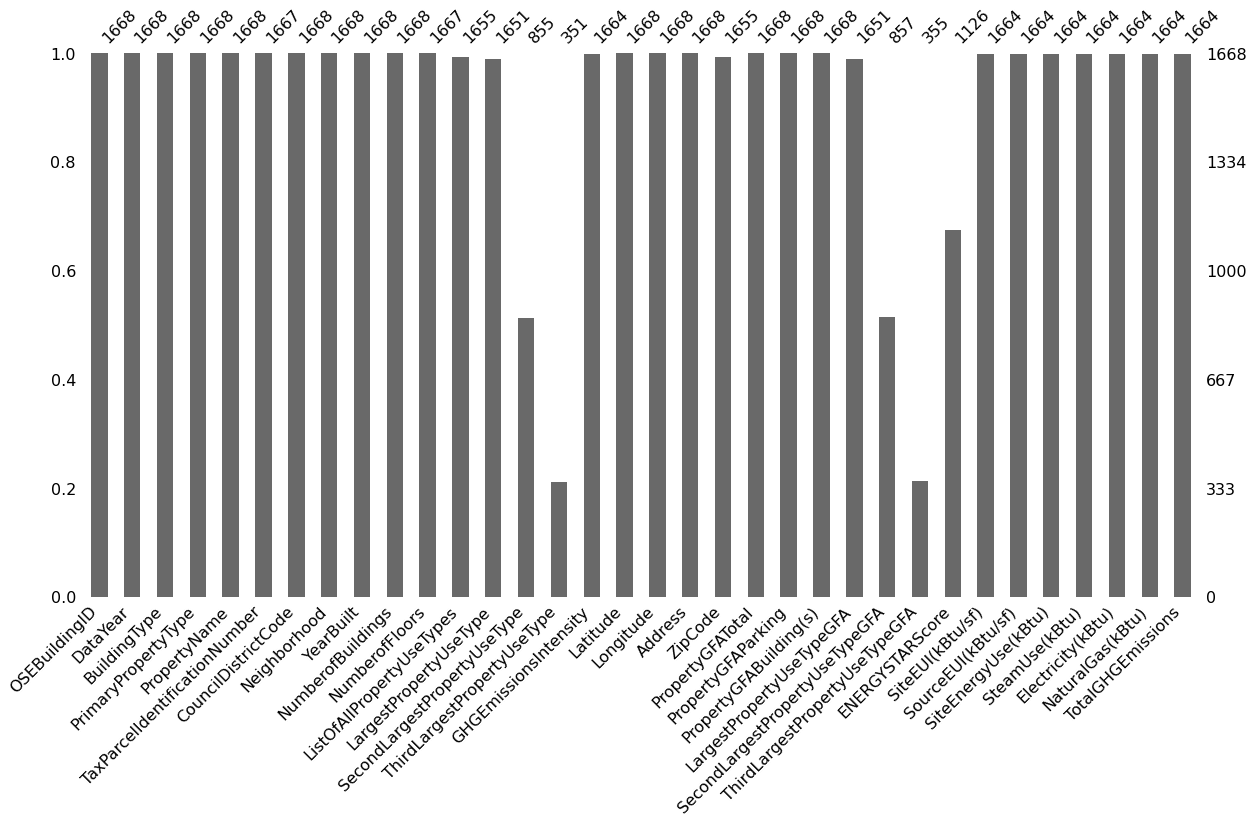

In [74]:
msno.bar(df_mean, figsize=(20,10))

In [75]:
df_mean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1668 entries, 0 to 1667
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1668 non-null   int64  
 1   DataYear                         1668 non-null   int64  
 2   BuildingType                     1668 non-null   object 
 3   PrimaryPropertyType              1668 non-null   object 
 4   PropertyName                     1668 non-null   object 
 5   TaxParcelIdentificationNumber    1667 non-null   object 
 6   CouncilDistrictCode              1668 non-null   int64  
 7   Neighborhood                     1668 non-null   object 
 8   YearBuilt                        1668 non-null   int64  
 9   NumberofBuildings                1668 non-null   float64
 10  NumberofFloors                   1667 non-null   float64
 11  ListOfAllPropertyUseTypes        1655 non-null   object 
 12  LargestPropertyUseTy

In [76]:
df_test=df_mean.copy()

In [77]:
# On supprime les colonnes dont les données manquantes sont supérieurs à 35%
missing = df_mean.isnull().sum(axis=0)/len(df_mean)*100
mask = missing < 35
mask = mask[mask == True]
df_mean = df_mean.loc[:, mask.index]
df_mean.shape


(1668, 30)

#### Suppresion des colonnes non pertinentes

Le but du porjet est de prédire la consommation d'énergie dans le but de supprimer les relevés couteux pour les années à venir. Nous allons donc exclure toutes les données de relevés. En plus, il y a des variables de valeurs uniques ou pas utiles pour la prédiction à supprimer aussi

In [78]:
df_mean_reduit=df_mean.copy()
# relevés 
df_mean_reduit.drop(['NaturalGas(kBtu)', 'Electricity(kBtu)', 'SteamUse(kBtu)'], axis=1, inplace=True)



On peut éliminer également les données énergétique surfaciques et l'intensité de gaz émis

In [79]:
df_mean_reduit.drop(['SiteEUI(kBtu/sf)','SourceEUI(kBtu/sf)', 'GHGEmissionsIntensity'], axis=1, inplace=True)

In [80]:
df_mean_reduit.describe()

,OSEBuildingID,DataYear,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,Latitude,Longitude,ZipCode,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions
count,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1667.000000,1668.000000,1668.000000,1655.000000,1.668000e+03,1668.000000,1.668000e+03,1.651000e+03,1126.000000,1.664000e+03,1664.000000
mean,16292.393285,2015.918465,4.366307,1961.908873,1.169664,4.109778,47.616436,-122.332849,98116.876737,1.191595e+05,13605.226918,1.055542e+05,9.909373e+04,64.756661,8.481845e+06,184.709312
std,13751.963083,0.273737,2.186997,32.787404,2.931633,6.545203,0.048207,0.024558,18.383771,2.975964e+05,43365.272688,2.829691e+05,2.775862e+05,27.852266,3.028273e+07,743.346366
min,1.000000,2015.000000,1.000000,1900.000000,0.000000,0.000000,47.499331,-122.411820,98006.000000,1.128500e+04,-1.000000,-8.451000e+03,6.455000e+03,1.000000,1.715000e+04,-0.800000
25%,581.750000,2016.000000,2.000000,1930.000000,1.000000,1.000000,47.586422,-122.343280,98105.000000,2.947775e+04,0.000000,2.847525e+04,2.549050e+04,46.500000,1.246846e+06,20.481250
50%,21147.500000,2016.000000,4.000000,1965.000000,1.000000,2.000000,47.612710,-122.332955,98109.000000,4.928950e+04,0.000000,4.755700e+04,4.349500e+04,71.750000,2.560690e+06,50.405000
75%,24600.250000,2016.000000,7.000000,1989.000000,1.000000,4.000000,47.649760,-122.321475,98125.000000,1.069760e+05,0.000000,9.562450e+04,9.221450e+04,88.000000,6.968586e+06,140.650000
max,50226.000000,2016.000000,7.000000,2015.000000,111.000000,99.000000,47.733870,-122.258819,98199.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,100.000000,8.739237e+08,16870.980000


On constate : 
- Valeurs négatives sur des surfaces et émission des gaz (PropertyGFAParking	PropertyGFABuilding(s),TotalGHGEmissions)
- Valeurs nulles 'NumberofBuildings' et	'NumberofFloors'  
- 99 etages à inspecter  
- pour 111 buildings : ca correpond à l'université de washington seattle qui s'etend sur 634 ac. ce n'est pas une valeur aberrante (388 buildings) et ca correspond à la surface gigantesque maximale

## Traitement des valeurs abérrantes et manquantes

#### 'numberofbuilding' and 'numberoffloors'

In [81]:
print(len(df_mean_reduit.loc[(df_mean_reduit['NumberofBuildings']==0) | (df_mean_reduit['NumberofBuildings'].isna())]))
print(len(df_mean_reduit.loc[(df_mean_reduit['NumberofFloors']==0) | (df_mean_reduit['NumberofFloors'].isna())]))

52
17


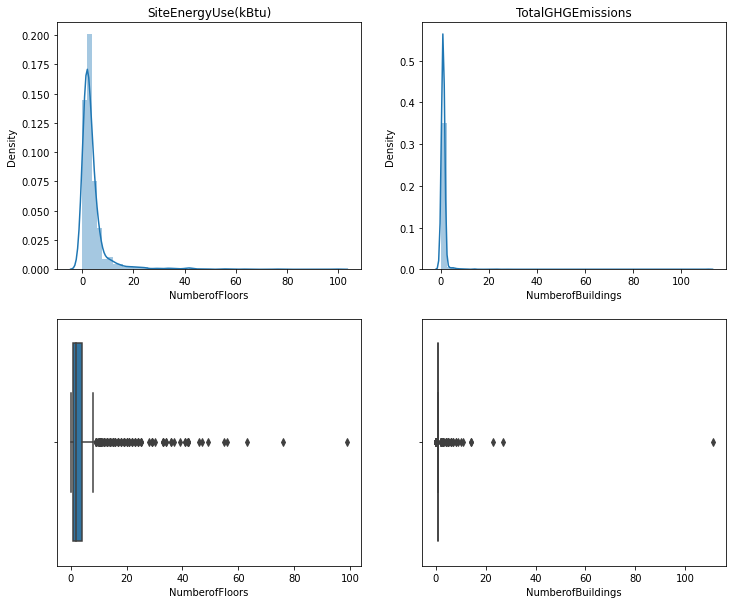

In [82]:
fig, ax = plt.subplots(figsize=(12,10))  
ax = plt.axes()

ax1=plt.subplot(2, 2, 1)
#ax1.set_xlim(-5,102)
sns.distplot(df_mean_reduit['NumberofFloors'], kde=True).set_title('SiteEnergyUse(kBtu)')

ax2=plt.subplot(2, 2, 2)
#ax2.set_xlim(-5,50)
sns.distplot(df_mean_reduit['NumberofBuildings'], kde=True).set_title('TotalGHGEmissions')

ax3=plt.subplot(2, 2, 3)
sns.boxplot(x=df_mean_reduit['NumberofFloors'])

ax4=plt.subplot(2, 2, 4)
sns.boxplot(x=df_mean_reduit['NumberofBuildings'])

plt.savefig('distribution build floor', dpi=200, bbox_inches='tight') 

pour numberofbuilding and numberoffloors remplacer les valeurs manquantes et nulles par la médiane de ces variables

In [83]:
mean_build=df_mean_reduit['NumberofBuildings'].median()
mean_floor=df_mean_reduit['NumberofFloors'].median()

df_mean_reduit['NumberofBuildings'].fillna(0, inplace=True)
df_mean_reduit['NumberofBuildings'].replace(0, mean_build, inplace=True)

df_mean_reduit['NumberofFloors'].fillna(0, inplace=True)
df_mean_reduit['NumberofFloors'].replace(0,mean_floor, inplace=True)



#### Valeurs négatives aberrantes

In [84]:
neg_col=['PropertyGFAParking', 'PropertyGFABuilding(s)','TotalGHGEmissions']
ind_drop=[]
for col in neg_col:
    ind_drop.append(df_mean_reduit.loc[df_mean_reduit[col]<0].index[0])
ind_drop

ind_drop=list(set(ind_drop))

df_mean_reduit.drop(ind_drop,0,inplace=True)



In [85]:
df_mean_reduit.shape

(1665, 24)

#### Valeurs manquantes sur les variables à prédire càd TotalGHGEmissions et SiteEnergyUse(kBtu) 

In [86]:
mask=df_mean_reduit.loc[(df_mean_reduit['SiteEnergyUse(kBtu)'].isna()) |  (df_mean_reduit ['TotalGHGEmissions'].isna())]


In [87]:
print(f"Il n' y a que {len(mask)} valeurs manquantes des variables à predire, on les supprime")

Il n' y a que 4 valeurs manquantes des variables à predire, on les supprime


In [88]:
df_mean_reduit = df_mean_reduit [~((df_mean_reduit['SiteEnergyUse(kBtu)'].isna()) | (df_mean_reduit ['TotalGHGEmissions'].isna()))]

### Traitement des outliers

Il est intéressant d'observer les distributions des variables à prédire pour savoir s'il y a des outliers autres que celles supprimées à partir de la variable 'outlier'

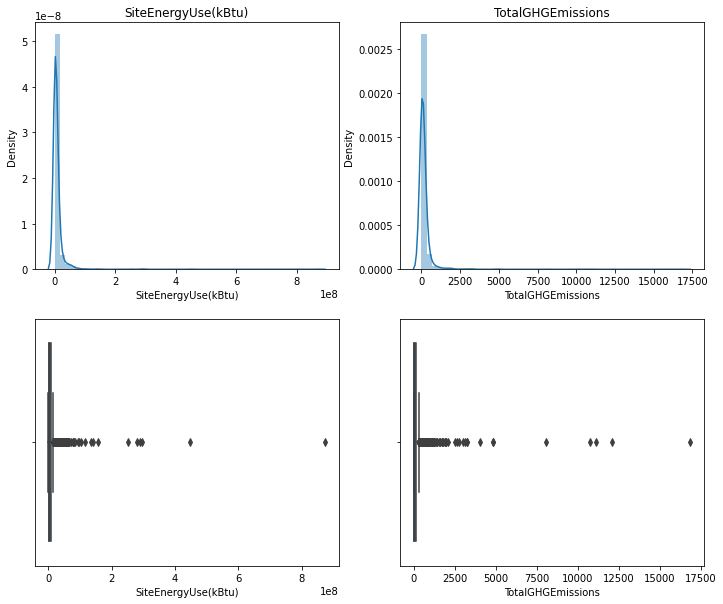

In [91]:
fig, ax = plt.subplots(figsize=(12,10))  
ax = plt.axes()

ax1=plt.subplot(2, 2, 1)
sns.distplot(df_mean_reduit['SiteEnergyUse(kBtu)'], kde=True).set_title('SiteEnergyUse(kBtu)')

ax2=plt.subplot(2, 2, 2)
sns.distplot(df_mean_reduit['TotalGHGEmissions'], kde=True).set_title('TotalGHGEmissions')

ax3=plt.subplot(2, 2, 3)
sns.boxplot(x=df_mean_reduit['SiteEnergyUse(kBtu)'])

ax4=plt.subplot(2, 2, 4)
sns.boxplot(x=df_mean_reduit['TotalGHGEmissions'])

plt.savefig('distribution energy et gaz', dpi=200, bbox_inches='tight') 

In [92]:
df_outliers=df_mean_reduit.copy()

IQR = stats.iqr(df_outliers['TotalGHGEmissions'], interpolation = 'midpoint') 

Q1 = np.percentile(df_outliers['TotalGHGEmissions'], 25, interpolation = 'midpoint') 
Q3 = np.percentile(df_outliers['TotalGHGEmissions'], 75, interpolation = 'midpoint')
low_lim_CO2 = Q1 - 1.5 * IQR 
up_lim_CO2 = Q3 + 3 * IQR 
print('low_limit is', low_lim_CO2) 
print('up_limit is', up_lim_CO2) 
IQR_eng= stats.iqr(df_outliers['SiteEnergyUse(kBtu)'], interpolation = 'midpoint') 
Q1 = np.percentile(df_outliers['SiteEnergyUse(kBtu)'], 25, interpolation = 'midpoint')  
Q3 = np.percentile(df_outliers['SiteEnergyUse(kBtu)'], 75, interpolation = 'midpoint')  
low_lim_eng= Q1 - 3 * IQR_eng 
up_lim_eng = Q3 + 3 * IQR_eng 
print('low_limit is', low_lim_eng) 
print('up_limit is', up_lim_eng) 


low_limit is -160.2825
up_limit is 502.66
low_limit is -15985448.0
up_limit is 24224442.0


In [93]:
df_outliers.loc[(df_outliers['SiteEnergyUse(kBtu)']>up_lim_eng) & 
                   (df_outliers['TotalGHGEmissions']>up_lim_CO2)].groupby(['CouncilDistrictCode','PrimaryPropertyType']).count()

OSEBuildingID  DataYear  \
CouncilDistrictCode PrimaryPropertyType                              
1                   Large Office                       1         1   
                    Senior Care Community              1         1   
                    University                         1         1   
2                   Large Office                       2         2   
                    Mixed Use Property                 1         1   
                    Other                              3         3   
3                   Hospital                           4         4   
                    Laboratory                         2         2   
                    Large Office                       1         1   
                    Medical Office                     3         3   
                    Other                              4         4   
                    University                         2         2   
4                   Hospital                           2         2   
                    Mixed Use Property                 1         1   
                    Other                              2         2   
                    University                         1         1   
5                   Hospital                           1         1   
                    Other                              1         1   
                    Retail Store                       1         1   
6                   Hospital                           1         1   
7                   Hotel                             10        10   
                    Laboratory                         4         4   
                    Large Office                      10        10   
                    Medical Office                     1         1   
                    Mixed Use Property                 6         6   
                    Other                              8         8   
                    Senior Care Community              1         1   
                    University                         1         1   

                                           BuildingType  PropertyName  \
CouncilDistrictCode PrimaryPropertyType                                 
1                   Large Office                      1             1   
                    Senior Care Community             1             1   
                    University                        1             1   
2                   Large Office                      2             2   
                    Mixed Use Property                1             1   
                    Other                             3             3   
3                   Hospital                          4             4   
                    Laboratory                        2             2   
                    Large Office                      1             1   
                    Medical Office                    3             3   
                    Other                             4             4   
                    University                        2             2   
4                   Hospital                          2             2   
                    Mixed Use Property                1             1   
                    Other                             2             2   
                    University                        1             1   
5                   Hospital                          1             1   
                    Other                             1             1   
                    Retail Store                      1             1   
6                   Hospital                          1             1   
7                   Hotel                            10            10   
                    Laboratory                        4             4   
                    Large Office                     10            10   
                    Medical Office                    1             1   
                    Mixed Use Property      

### A noter que la plupart des outliers se situent au district 7

In [94]:
mask=((df_outliers['SiteEnergyUse(kBtu)']>up_lim_eng) | (df_outliers['TotalGHGEmissions']>up_lim_CO2))


df_outliers=df_outliers[~mask]


<AxesSubplot:>

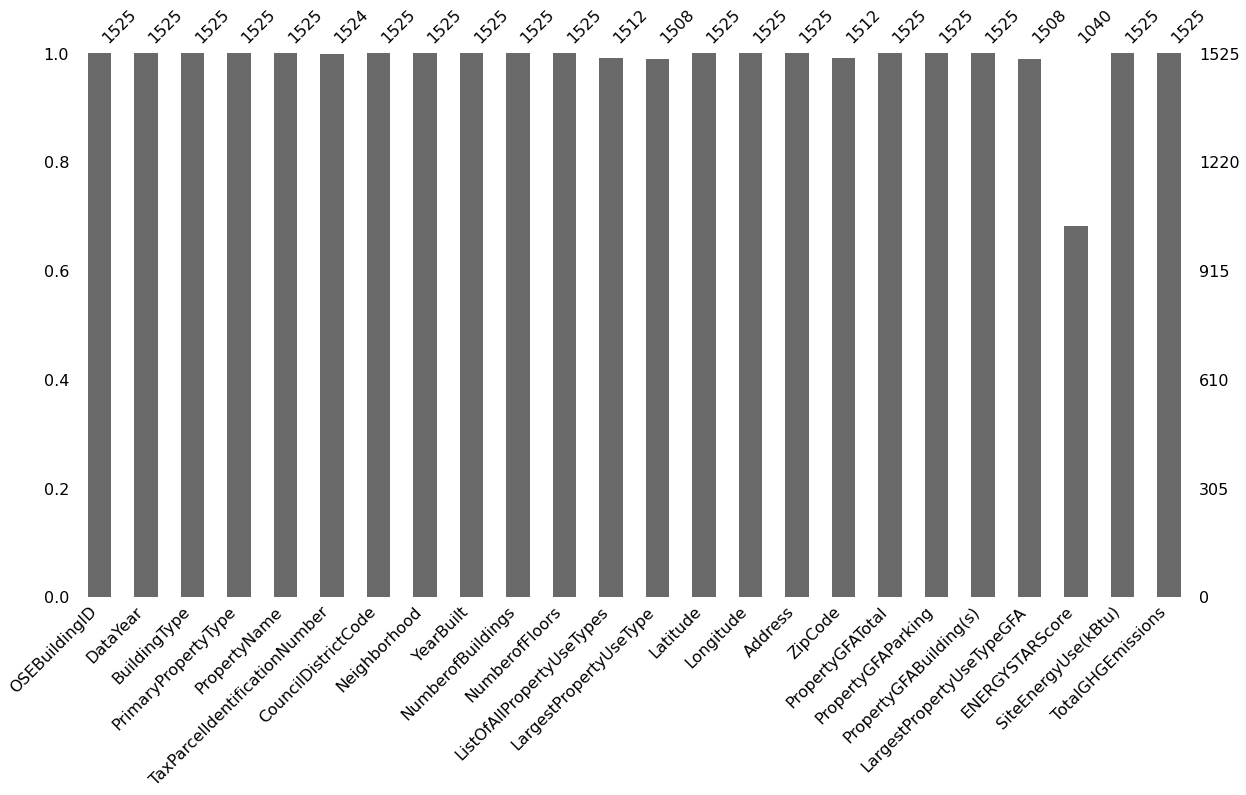

In [95]:

msno.bar(df_outliers, figsize=(20,10))

## <font color="blue" id="section_5"> E- Analyse exploratoire et feature engineering

In [97]:
df_exp=df_outliers.copy()

### Analyse multivariée 

#### Correlation entre les variables

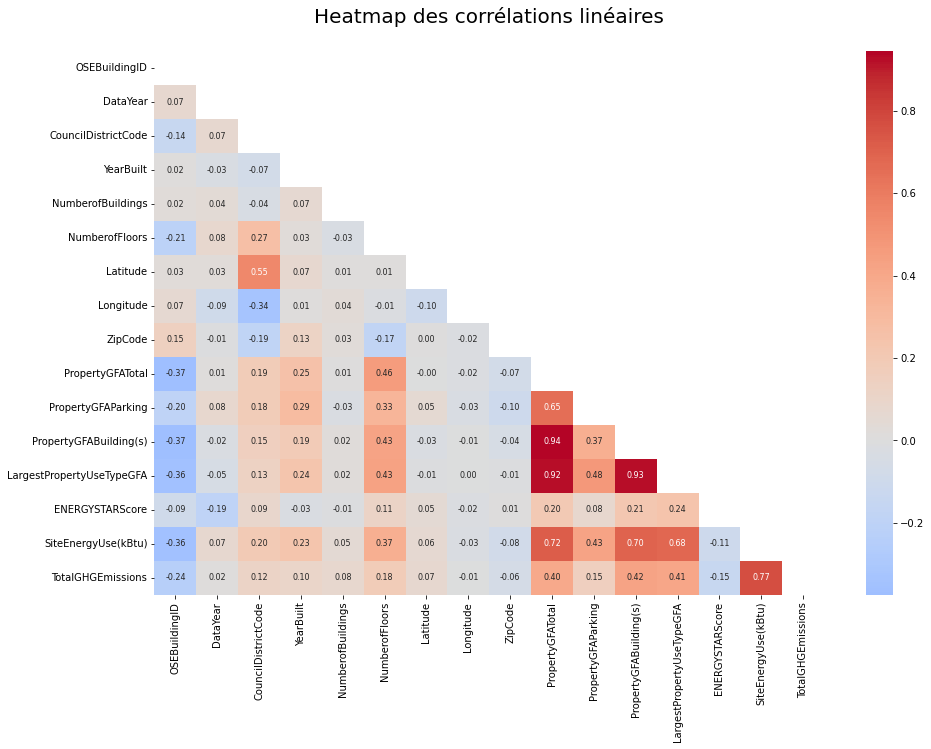

In [98]:
corr = df_outliers.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size':8}, 
                 mask=mask, center=0, cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n", fontsize=20)
plt.savefig('heat_map', dpi=200, bbox_inches='tight') 

- La consommation totale d'énergie est fortement corrélée à la surface des bâtiments
- Les émissions de Co2 sont fortement corrélées à la consommation totale d'énergie
- 'PropertyGFATotal', 'PropertyGFABuilding(s)' et LargestPropertyUseTypeGFA' sont fortement corrrélées. donc supprimées deux des 3 pour éviter la redondance d'informations


In [99]:
#On supprime 'PropertyGFABuilding(s)' et LargestPropertyUseTypeGFA'

df_exp.drop(['LargestPropertyUseTypeGFA','PropertyGFABuilding(s)'], axis=1, inplace=True)

### Analyse univariée

In [100]:
# Variables catégorielles
cat = list(df_exp.select_dtypes(include='object').columns)

# Variables numériques
num = list(df_exp.select_dtypes(include=['int64','float64']).columns)

In [101]:
# convertir les variables objects 'Latitude' et 'Longitude' en numeric
df_exp ['Latitude'] = df_exp.Latitude.astype(float)
df_exp ['Longitude'] = df_exp.Longitude.astype(float)

In [102]:
# Variables catégorielles
cat = list(df_exp.select_dtypes(include='object').columns)

# Variables numériques
num = list(df_exp.select_dtypes(include=['int64','float64']).columns)

print('variables categorielles :', cat)

print('variables numeriques :', num)


variables categorielles : ['BuildingType', 'PrimaryPropertyType', 'PropertyName', 'TaxParcelIdentificationNumber', 'Neighborhood', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'Address']
variables numeriques : ['OSEBuildingID', 'DataYear', 'CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'Latitude', 'Longitude', 'ZipCode', 'PropertyGFATotal', 'PropertyGFAParking', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions']


Il y a les variables caractéritiques des batiments comme le ID 'OSEBuildingID et l'adresse et qui ne sont pas utiles pour la prediction car l'ID est unique et nous avons la localisation de chaque batiment (longitude et latitude). On va les separer dans un dataframe comme identifiant 

In [103]:
#Isoler les identifiants des batiments qui ne peuvent pas servir dans la prédiction

id_building = ['OSEBuildingID', 'PropertyName','TaxParcelIdentificationNumber',  'Address', 'ZipCode']
df_id_building= df_exp[id_building]
df_exp.drop(id_building, axis=1, inplace=True)

### Distribution des variables numériques
(a l'exception de celles a predire)

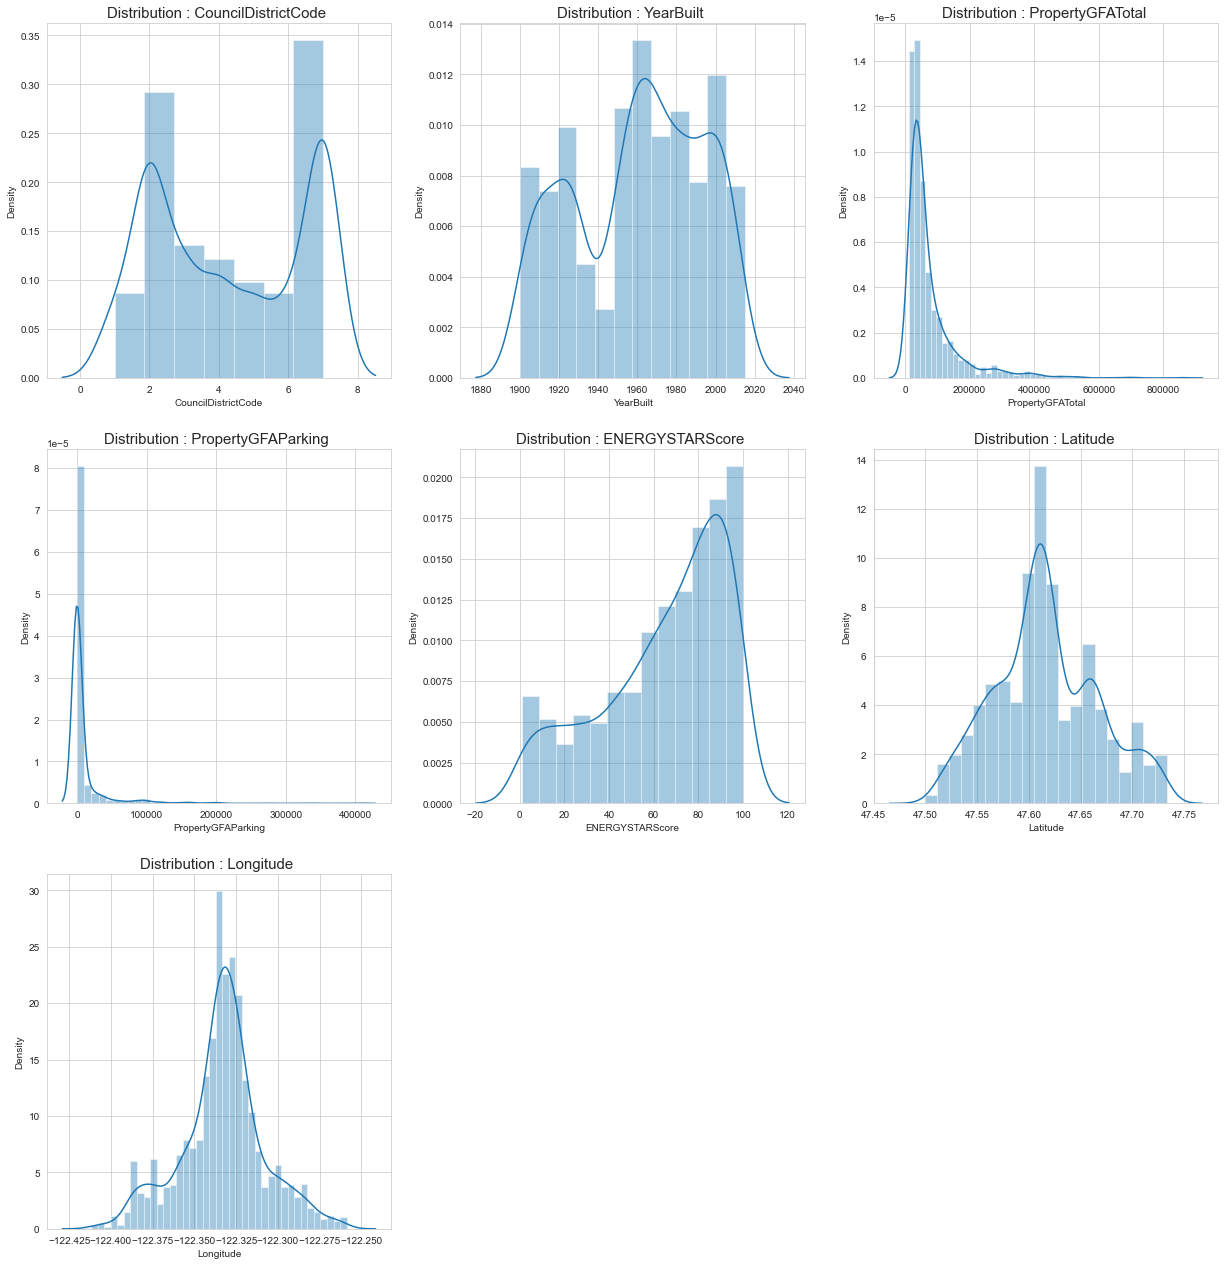

In [104]:
num_dis=['CouncilDistrictCode',
 'YearBuilt',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'ENERGYSTARScore','Latitude', 'Longitude']

sns.set_style("whitegrid")
fig = plt.figure(figsize=(21,30))

sub = 0
for i in range(len(num_dis)):
    fig.add_subplot(4,3,i+1)
    
    left, width = 0, 1
    bottom, height = 0, 1
    right = left + width
    top = bottom + height
    
    colonne = num_dis[i]
    ax = sns.distplot(df_exp[colonne])
    ax.set_title(f"Distribution : {colonne} ", fontsize=15)
    sub += 1
plt.savefig('distribution_var_num', dpi=200, bbox_inches='tight') 
plt.show()      

On peut consater que : 
- 'CouncilDistrictCode' : plus que la moitié des batiments sont dans les districts 2 et 7. Les autres districts sont probablement des quartiers résidentiels. Cette variabale est plutôt catégorielle donc on va le convertir en "string"
- 'YearBuilt' : peu de construction bâtie entre 1930 et 1947 ce qui est expliqué par la crise de 29 et la 2nde guerre mondiale. Il y a peu de construction récentes. Il serait intéressant de remplacer l'année de construction par l'âge des bâtiments pour réduire la dispersion des données et la lier à l'année des relevés. Nous allons donc créer cette nouvelle variable et supprimer l'année de construction
- EnergyStarScore est un score entre 1 et 100 qui reflète l'efficacité énergétique d'un bâtiment parmi les bâtiments similaires déjà certifiés. Un score de 50 signifie qu'il est dans la médiane alors qu'un score au dessus de 75 indique qu'il s'agit d'un bâtiment à haute performance. Etonnement, la majorité des batiments ont un score supérieure à la médiane

In [105]:
# Convertir variable 'CouncilDistrictCode' en variable catégorielle
df_exp["CouncilDistrictCode"] = df_exp["CouncilDistrictCode"].apply(str)

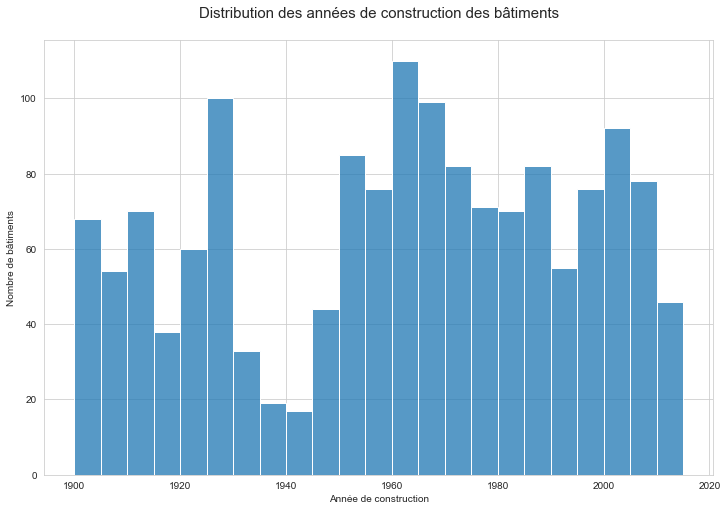

In [106]:
fig = plt.figure(figsize=(12,8))
ax = sns.histplot(data=df_exp, x='YearBuilt', bins=int((df_exp.YearBuilt.max()- df_exp.YearBuilt.min())/5))
                                                              
ax.set_xlabel("Année de construction")
ax.set_ylabel("Nombre de bâtiments")
plt.title(f"Distribution des années de construction des bâtiments\n",fontsize=15)
plt.savefig('building year construction', dpi=200, bbox_inches='tight') 
plt.show()

### Création de variable age des batiments 

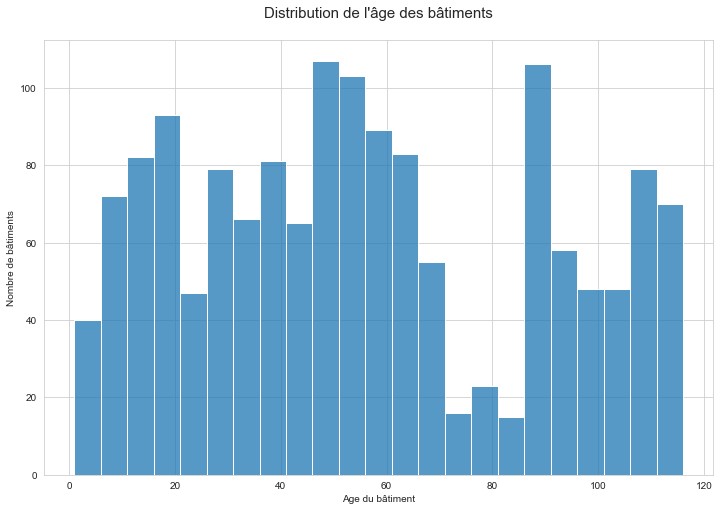

In [107]:
# Création variable age des batiments 
df_exp['BuildingAge'] = df_exp['DataYear'] - df_exp['YearBuilt']


fig = plt.figure(figsize=(12,8))
ax = sns.histplot(data=df_exp, x='BuildingAge', bins=int((df_exp.BuildingAge.max() - df_exp.BuildingAge.min())/5))
ax.set_xlabel("Age du bâtiment")
ax.set_ylabel("Nombre de bâtiments")
plt.title(f"Distribution de l'âge des bâtiments\n", fontsize=15)
plt.savefig('building age', dpi=200, bbox_inches='tight') 

In [108]:
df_exp.drop(['YearBuilt', 'DataYear'], axis=1, inplace=True)

### Variables à prédire 'SiteEnergyUse(kBtu)' et 'TotalGHGEmissions'

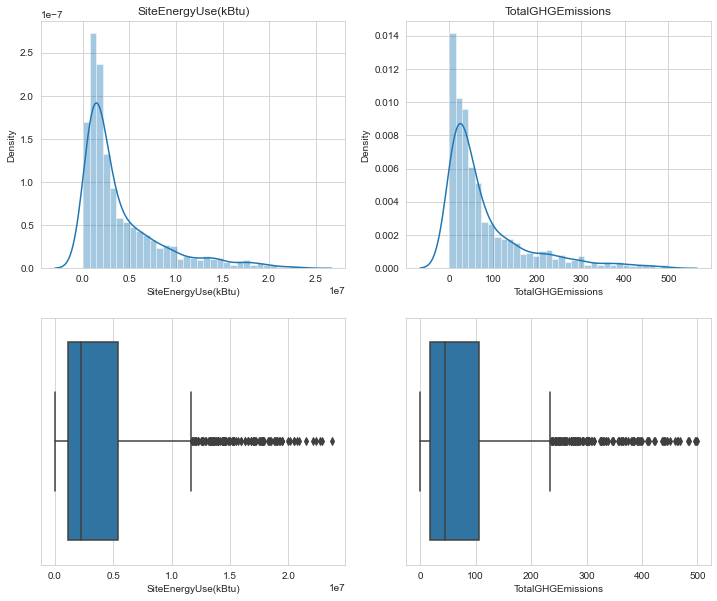

In [109]:
fig, ax = plt.subplots(figsize=(12,10))  
ax = plt.axes()

ax1=plt.subplot(2, 2, 1)
#ax1.set_xlim(-5,102)
sns.distplot(df_outliers['SiteEnergyUse(kBtu)'], kde=True).set_title('SiteEnergyUse(kBtu)')

ax2=plt.subplot(2, 2, 2)
#ax2.set_xlim(-5,50)
sns.distplot(df_outliers['TotalGHGEmissions'], kde=True).set_title('TotalGHGEmissions')

ax3=plt.subplot(2, 2, 3)
sns.boxplot(x=df_outliers['SiteEnergyUse(kBtu)'])

ax4=plt.subplot(2, 2, 4)
sns.boxplot(x=df_outliers['TotalGHGEmissions'])

plt.savefig('distribution energy et gaz wo', dpi=200, bbox_inches='tight') 

- Beaucoup de batiments consomment peu d'énergie 
- Certains batiments consomment une quantité importante d'énergie mais ils ne sont pas très nombreux, je note que j'ai déjà enlever les outliers de consommation énergétique
- Pareil pour l'émission de gaz à effet de serre

#### Scatterplot des variables à prédires :

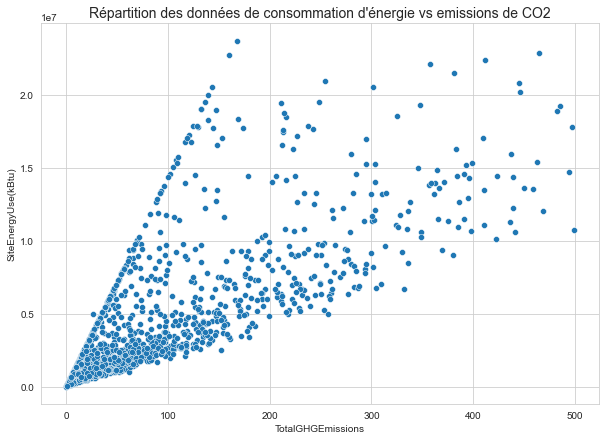

In [110]:
fig = plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_exp, x="TotalGHGEmissions", y="SiteEnergyUse(kBtu)" )
plt.title("Répartition des données de consommation d'énergie vs emissions de CO2", fontsize=14)
plt.savefig('scatter plot energy et gaz wo', dpi=200, bbox_inches='tight') 
plt.show()

La répartion des données de la consommation d'énergie en fonction d'émission de gaz à effet de serre ne suivent pas uniquement une droite de régression linéaire

### Répartition en fonction du type de bâtiments

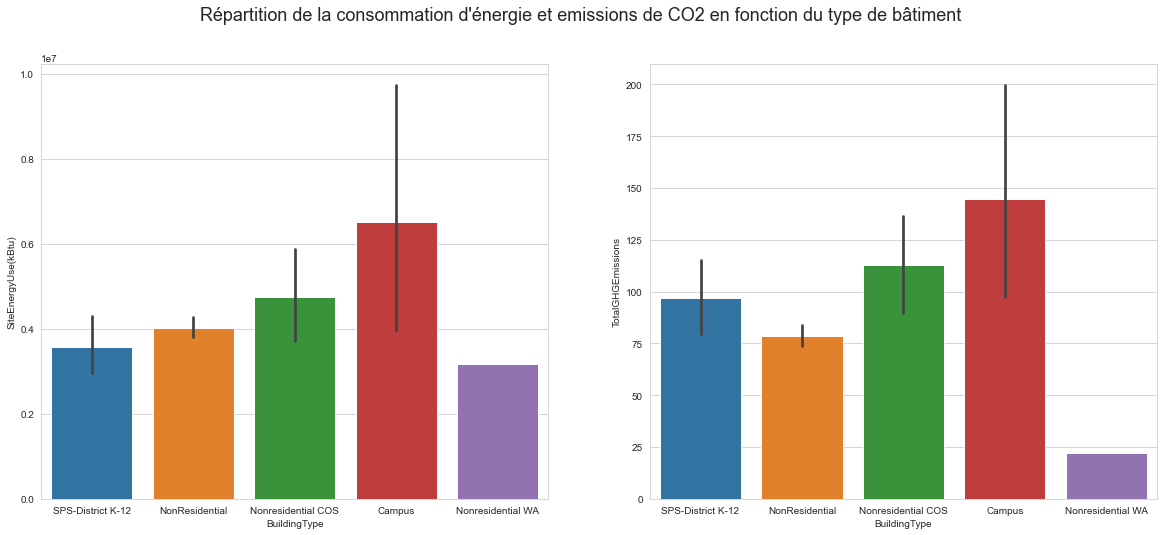

In [111]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.barplot(x='BuildingType',y='TotalGHGEmissions',data=df_exp, ax=axes[1])
sns.barplot(x='BuildingType',y='SiteEnergyUse(kBtu)',data=df_exp, ax=axes[0])
plt.suptitle("Répartition de la consommation d'énergie et emissions de CO2 en fonction du type de bâtiment", 
              fontsize=18)
plt.savefig('building type, energy et gaz', dpi=200, bbox_inches='tight') 
plt.show()

Les campus suivis par les Nonresidentiel COS, consomment le plus d'énergie et rejettent le plus de gaz

### Répartition en fonction de l'âge de bâtiments 

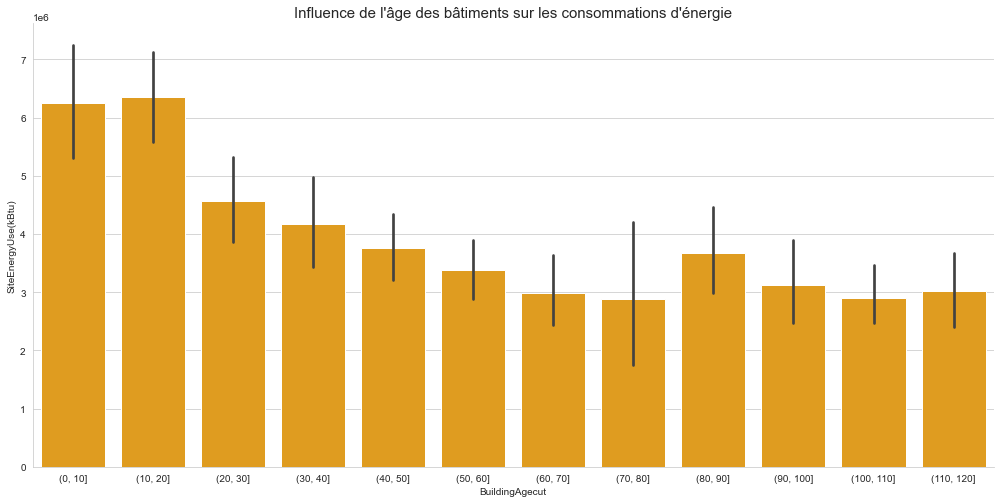

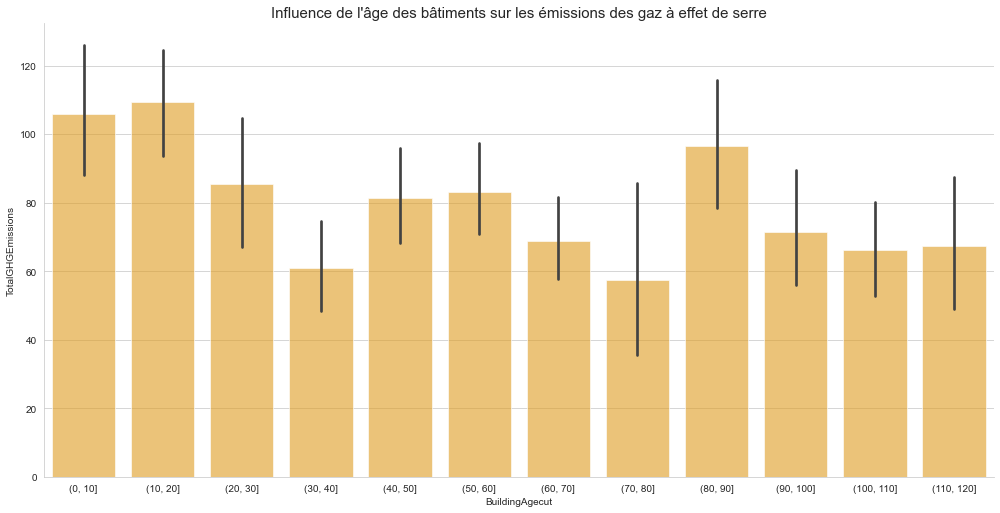

In [113]:
bins = pd.IntervalIndex.from_tuples([(0, 10), (10, 20), (20, 30), (30, 40), (40, 50), 
                                     (50, 60), (60, 70), (70,80), (80,90), (90,100), 
                                     (100,110), (110,120)])
df_age=df_exp.copy()
df_age['BuildingAgecut']=pd.cut(df_age['BuildingAge'], bins=bins)

sns.catplot(x="BuildingAgecut", y="SiteEnergyUse(kBtu)", data=df_age,  kind="bar", height=7, aspect=2, color="orange")
plt.title("Influence de l'âge des bâtiments sur les consommations d'énergie", fontsize=15)
plt.savefig('building age energy consumption', dpi=200, bbox_inches='tight') 
plt.show()


sns.catplot(x="BuildingAgecut", y="TotalGHGEmissions", data=df_age,  kind="bar", height=7, aspect=2, color="orange",  alpha=.6)
plt.title("Influence de l'âge des bâtiments sur les émissions des gaz à effet de serre", fontsize=15)
plt.savefig('building age gaz emission', dpi=200, bbox_inches='tight') 
plt.show()


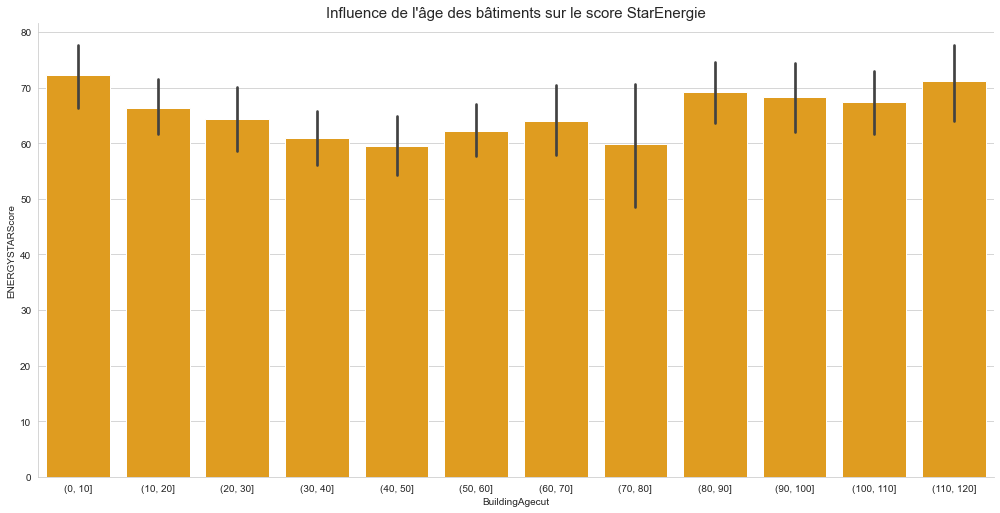

In [114]:
sns.catplot(x="BuildingAgecut", y="ENERGYSTARScore", data=df_age,  kind="bar", height=7, aspect=2, color="orange")
plt.title("Influence de l'âge des bâtiments sur le score StarEnergie", fontsize=15)
plt.savefig('building age EnergyStarScore', dpi=200, bbox_inches='tight') 
plt.show()



Etonnement, les batiments les plus récents sont ceux qui consomment plus d'énergie et émettent plus de gaz. Est ce que cela est lié à leur surface par exemple? 

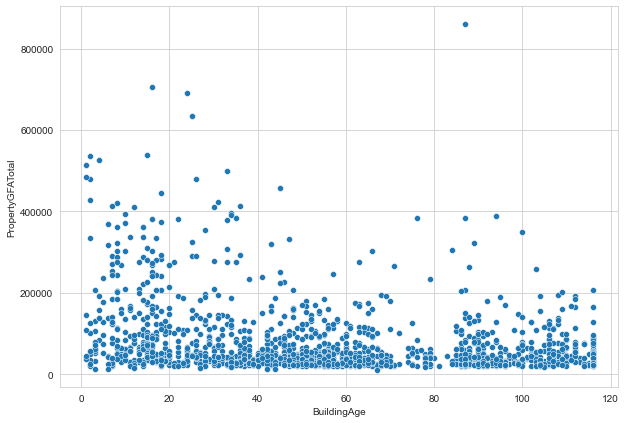

In [115]:
fig = plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_exp, x='BuildingAge', y='PropertyGFATotal')
plt.savefig('scattet building age totale surface', dpi=200, bbox_inches='tight') 

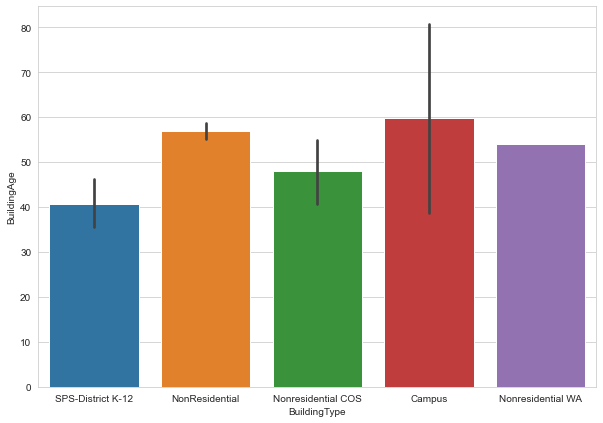

In [116]:
fig = plt.figure(figsize=(10, 7))
sns.barplot(data=df_exp, x='BuildingType', y='BuildingAge')
plt.savefig('bar building age-build type', dpi=200, bbox_inches='tight') 

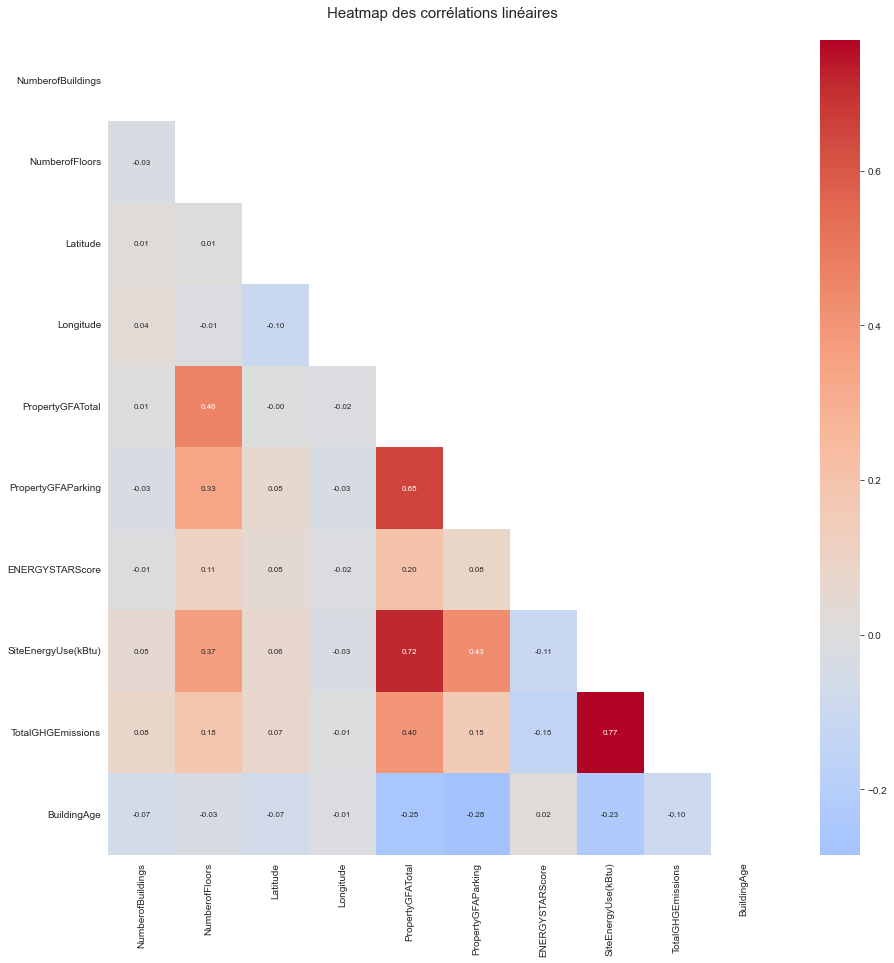

In [117]:
corr = df_age.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size':8}, 
                 mask=mask, center=0, cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n", fontsize=15)
plt.savefig('heat map corr  build age', dpi=200, bbox_inches='tight') 


L'age de batiment n'est corrélé à aucune variable caractérisant la taille du batiment 

### Géolocalisation des bâtiments et de leur consommation d'énergie et émission de gaz



<IPython.core.display.Javascript object>


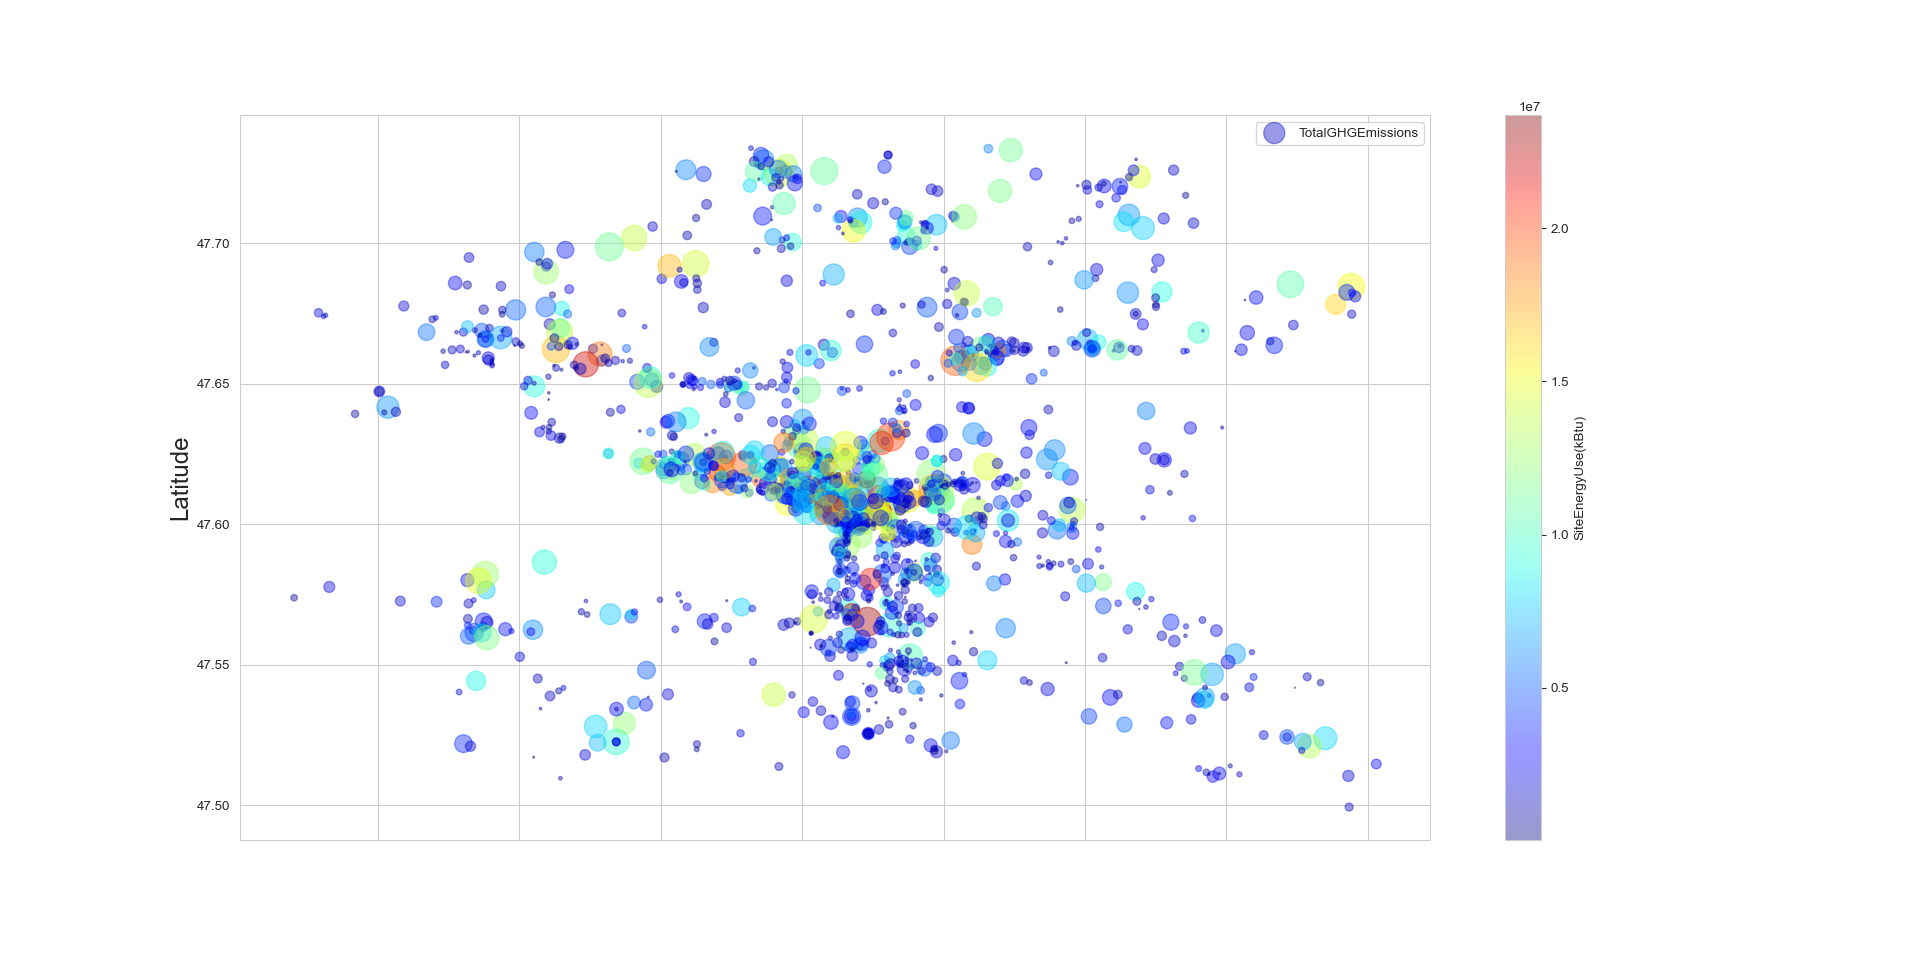

In [161]:
df_exp.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.4,
            s=df_exp["TotalGHGEmissions"], label="TotalGHGEmissions",
            c='SiteEnergyUse(kBtu)', cmap=plt.get_cmap("jet"), colorbar=True,
            figsize=(20,10))
plt.xlabel('Longitude', fontsize=18)
plt.ylabel('Latitude', fontsize=18)
plt.savefig('localisation geographique energie emission', dpi=200, bbox_inches='tight') 
plt.show()

- La taille des cercles représentent l'émission des gaz. La couleur selon la barre représente la consommation d'energie.  

Il y a une très forte densité de bâtiments au centre géographique

Il y a quelques bâtiments a fort consommation d'énergie et a fort émission de gaz (les grands cercles rouges orangés)

Il n'y a pas de séparation visuelle franche selon la localisation géographique 

### Variables catégorielles

In [119]:
# Variables catégorielles

cat = list(df_exp.select_dtypes(include='object').columns)
df_exp[cat].nunique()

BuildingType                   5
PrimaryPropertyType           24
CouncilDistrictCode            7
Neighborhood                  19
ListOfAllPropertyUseTypes    331
LargestPropertyUseType        54
dtype: int64

#### Les types de bâtiments

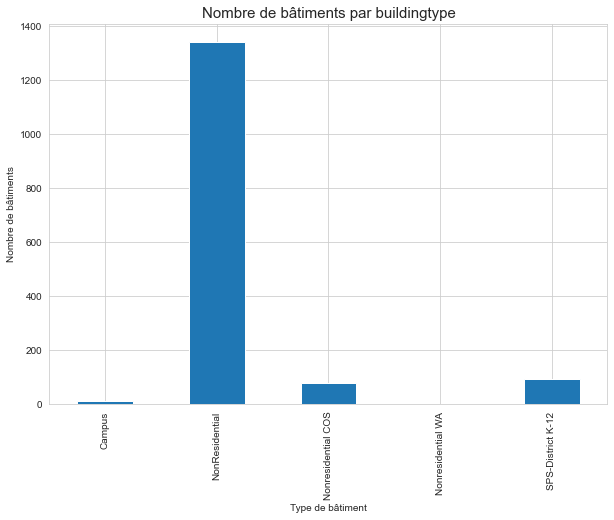

In [120]:
fig = plt.figure(figsize=(10, 7))
ax = plt.axes()

df_exp['BuildingType'].value_counts().sort_index(axis=0).plot(kind='bar')
ax.set_xlabel("Type de bâtiment")
ax.set_ylabel("Nombre de bâtiments")
plt.title(f"Nombre de bâtiments par buildingtype", fontsize=15)
plt.savefig('barplot build type', dpi=200, bbox_inches='tight') 


Les types de batiments sont inégalement représentés comme on peut le constater

In [121]:
df_exp['BuildingType'].value_counts()

df_exp.loc[df_exp['BuildingType']=='Nonresidential WA']


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,NumberofBuildings,NumberofFloors,ListOfAllPropertyUseTypes,LargestPropertyUseType,Latitude,Longitude,PropertyGFATotal,PropertyGFAParking,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,BuildingAge
1654,Nonresidential WA,University,4,NORTHEAST,1.0,1.0,College/University,College/University,47.66127,-122.31256,68072.0,0.0,NaN,3180819.25,22.17,54


Il y a une seule valeure pour le type 'Nonresidential WA' qui est Burke Museum c'est une musée des fossiles située sur le campus de l'université de Washington.Je le mets avec le type non residentiel


In [122]:
df_exp["BuildingType"].replace({"Nonresidential WA": "NonResidential"}, inplace=True)


Cela ne change en rien que les types de bâtiments restent inégalement représentés (plus que 88% sont de types non résidentiels) ce qui posera un problème pour un modèle d'apprentissage. En plus, on trouve le meme type de porpriété (k-12 school à titre d'exemple) dans différents type de batiments ("NonResidentiel" et "SPS-District K-12", etc). Je choisis de ne pas utiliser cette variable dans la partie modélisation. 

#### Quelles sont les diverses catégories de bâtiments représentés?

#### PrimaryPropertyType           

In [123]:
df_exp['PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    287
Other                          223
Warehouse                      184
K-12 School                    131
Large Office                   129
Mixed Use Property             100
Retail Store                    91
Worship Facility                72
Hotel                           61
Distribution Center             51
Supermarket / Grocery Store     39
Medical Office                  35
Self-Storage Facility           28
Residence Hall                  21
University                      17
Senior Care Community           15
Refrigerated Warehouse          12
Restaurant                      11
Non-Refrigerated Warehouse       5
SPS-District K-12                4
Laboratory                       4
Low-Rise Multifamily             3
Restaurant\n                     1
Hospital                         1
Name: PrimaryPropertyType, dtype: int64

In [124]:
# Débarrassons des répétitions avec des caractères différentes
df_exp['PrimaryPropertyType'] =df_exp['PrimaryPropertyType'].str.strip().str.lower().replace('\n','')

In [125]:
df_exp['PrimaryPropertyType'].value_counts()

small- and mid-sized office    287
other                          223
warehouse                      184
k-12 school                    131
large office                   129
mixed use property             100
retail store                    91
worship facility                72
hotel                           61
distribution center             51
supermarket / grocery store     39
medical office                  35
self-storage facility           28
residence hall                  21
university                      17
senior care community           15
restaurant                      12
refrigerated warehouse          12
non-refrigerated warehouse       5
sps-district k-12                4
laboratory                       4
low-rise multifamily             3
hospital                         1
Name: PrimaryPropertyType, dtype: int64

----------------------------------------------------------------------------------------------------------------------------
- Nous avons une seule valeur correspondant au type hopital à supprimer donc sinon ca posera un problème pour le modèle d'apprentissage (si cette valeur se trouve dans la partie test, le modèle entrainé ne la reconnaitra pas. Il y avait 9 avant de supprimer les outliers. Malheureusement le futur modèle ne pourra pas prédire la consommation énergétique des batiments de types hopital.  
- Pour low-rise-family on a que 3 valeurs, je les supprime aussi car ce sont des batiments destinés à l'habitation.  
- 'k-12 school' et 'sps-district k-12' correspond au même type de propriétés (k-12: école de la maternelle au secondaire). Je les regroupe dans la même catégorie
----------------------------------------------------------------------------------------------------------------------------


In [126]:
# Suppresion des bâtiments de type Hospital et low-rise multifamily 
to_drop=['hospital', 'low-rise multifamily']
df_exp = df_exp.loc[~df_exp["PrimaryPropertyType"].isin(to_drop)]


In [127]:
df_exp['PrimaryPropertyType'].replace({"sps-district k-12": "k-12 school"}, inplace=True)

In [128]:
list_PrimaryPropertyType=df_exp['PrimaryPropertyType'].unique().tolist()

In [129]:
print(f" {len(df_exp['PrimaryPropertyType'].value_counts())} valeurs à encoder restent correcte pour cette variable catégorielle")

 20 valeurs à encoder restent correcte pour cette variable catégorielle


<IPython.core.display.Javascript object>


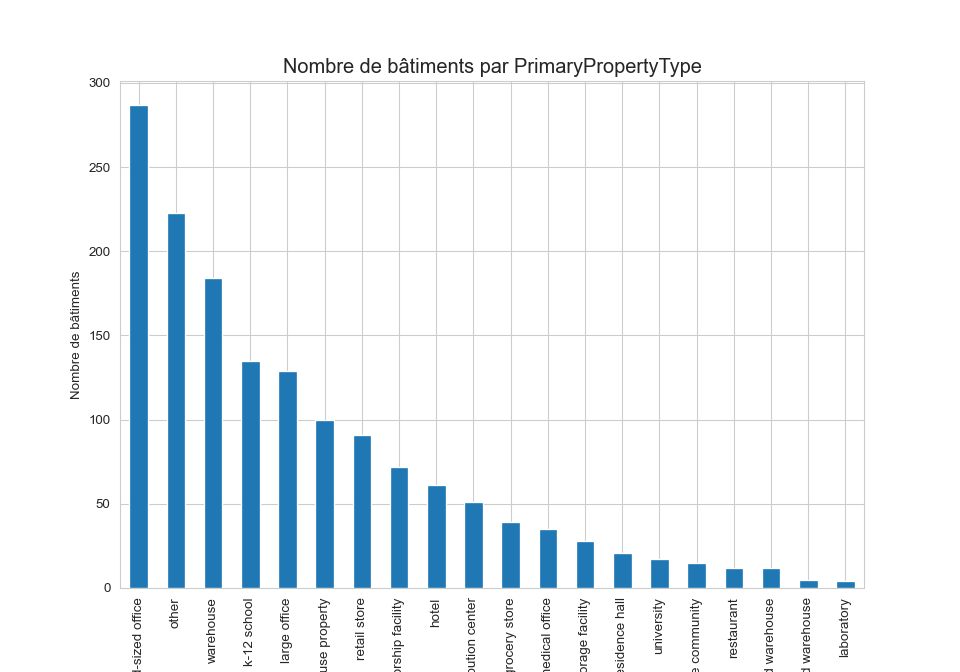

In [165]:
fig = plt.figure(figsize=(10, 7))
ax = plt.axes()

df_exp['PrimaryPropertyType'].value_counts().sort_values(ascending=False).plot(kind='bar')
ax.set_xlabel("Utilisation primaire")
ax.set_ylabel("Nombre de bâtiments")
plt.title(f"Nombre de bâtiments par PrimaryPropertyType", fontsize=15)
plt.savefig('barplot primaryproptype', dpi=200, bbox_inches='tight')

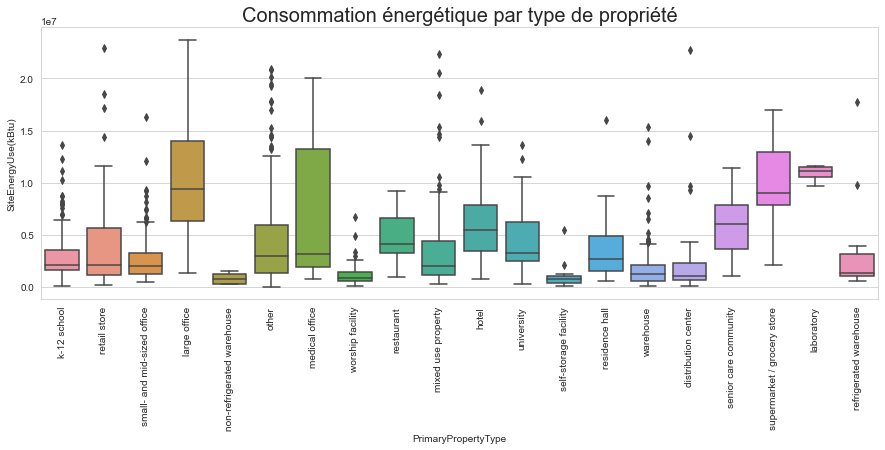

In [130]:
# Consommation énergétique par type de propriété

fig = plt.figure(1, figsize=(15,5))
sns.boxplot(data=df_exp, x="PrimaryPropertyType" , y="SiteEnergyUse(kBtu)")
plt.xticks(rotation=90)
plt.title(f"Consommation énergétique par type de propriété", fontsize=20)
plt.savefig('Consommation énergétique par type de propriété', dpi=200, bbox_inches='tight') 
plt.show()

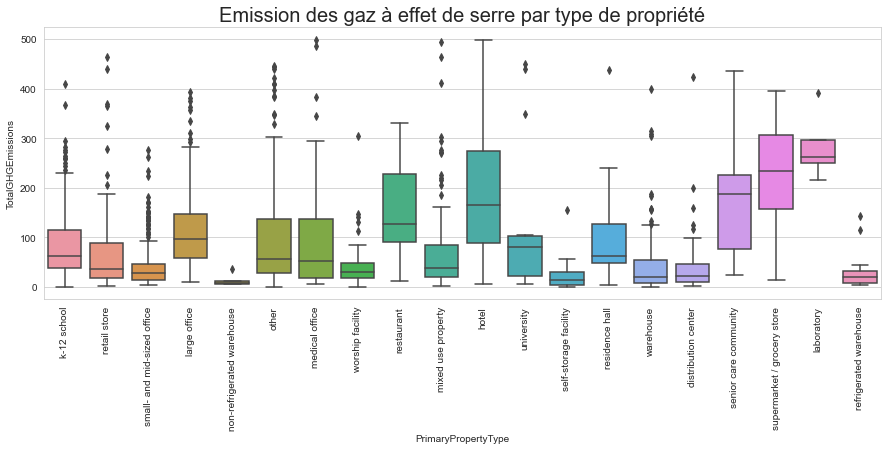

In [131]:
# Emission des gaz à effet de serre par type de propriété

fig = plt.figure(1, figsize=(15,5))
sns.boxplot(data=df_exp, x="PrimaryPropertyType" , y='TotalGHGEmissions')
plt.xticks(rotation=90)
plt.title(f"Emission des gaz à effet de serre par type de propriété", fontsize=20)
plt.savefig('Emission de gaz à effet de serre par type de propriété', dpi=200, bbox_inches='tight') 
plt.show()

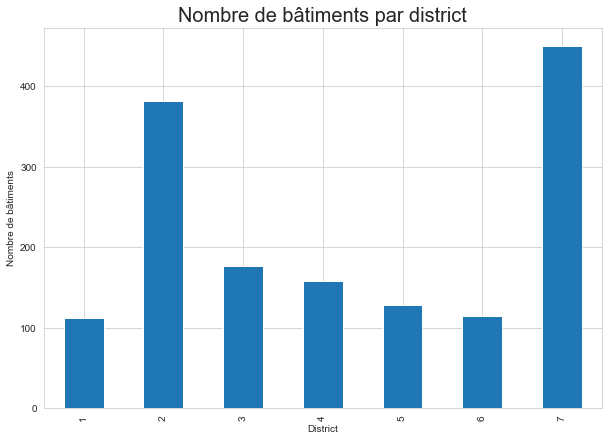

In [132]:
fig = plt.figure(figsize=(10, 7))
ax = plt.axes()

df_exp['CouncilDistrictCode'].value_counts().sort_index(axis=0).plot(kind='bar')
ax.set_xlabel("District")
ax.set_ylabel("Nombre de bâtiments")
plt.title(f"Nombre de bâtiments par district", fontsize=20)
plt.savefig('barplot district', dpi=200, bbox_inches='tight') 

#### Neighborhood

Text(0, 0.5, 'Nombre de bâtiments')

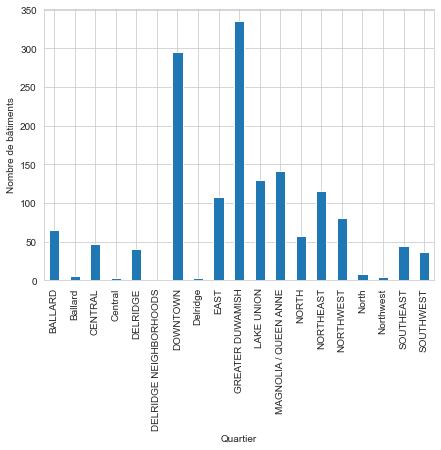

In [133]:
fig = plt.figure(figsize=(7,5))
ax = plt.axes()  

df_exp['Neighborhood'].value_counts().sort_index(axis=0).plot(kind='bar')
ax.set_xlabel("Quartier")
ax.set_ylabel("Nombre de bâtiments")


In [134]:
# Débarrassons des répétitions avec des caractères différentes
df_exp['Neighborhood']=df_exp['Neighborhood'].str.lower()
df_exp['Neighborhood'].replace('delridge neighborhoods', 'delridge', inplace=True)

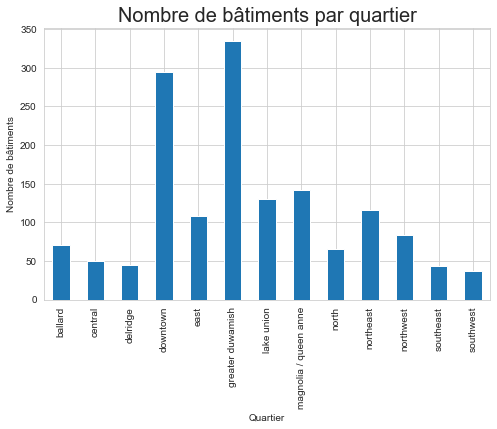

In [135]:
fig = plt.figure(figsize=(8,5))
ax = plt.axes()  

df_exp['Neighborhood'].value_counts().sort_index(axis=0).plot(kind='bar')
ax.set_xlabel("Quartier")
ax.set_ylabel("Nombre de bâtiments")
plt.title(f"Nombre de bâtiments par quartier", fontsize=20)
plt.savefig('barplot quartier', dpi=200, bbox_inches='tight')

Encore une fois, certains quartiers sont très peu représentés, probablement les quartiers résidentiels avec les données qu'on a supprimé de l'analyse. Les quartiers les plus représentés sont 'greater duwamish' et 'downtown

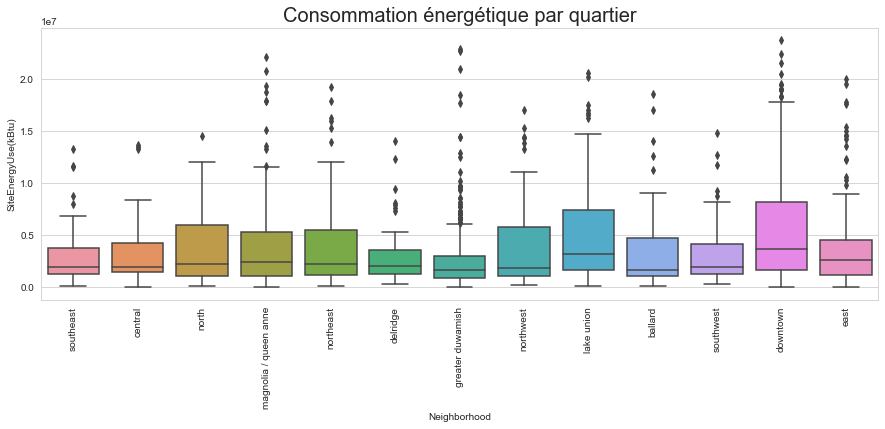

In [136]:
# Consommation énergétique par quartier

fig = plt.figure(1, figsize=(15,5))
sns.boxplot(data=df_exp, x="Neighborhood" , y="SiteEnergyUse(kBtu)")
plt.xticks(rotation=90)
plt.title(f"Consommation énergétique par quartier", fontsize=20)
plt.savefig('Consommation énergétique par quartier', dpi=200, bbox_inches='tight') 

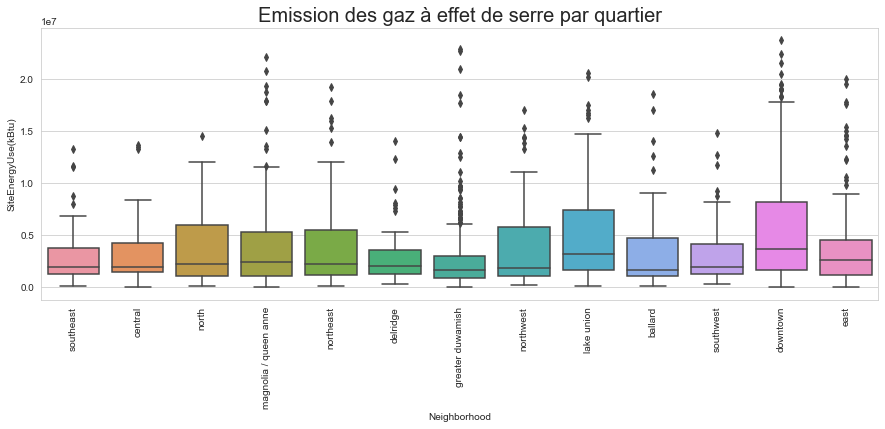

In [137]:
# Emission des gaz à effet de serre par quartier

fig = plt.figure(1, figsize=(15,5))
sns.boxplot(data=df_exp, x="Neighborhood" , y="SiteEnergyUse(kBtu)")
plt.xticks(rotation=90)
plt.title(f"Emission des gaz à effet de serre par quartier", fontsize=20)
plt.savefig('Emission des gaz à effet de serre par quartier', dpi=200, bbox_inches='tight') 


#### ListOfAllPropertyUseTypes

In [138]:
df_exp['ListOfAllPropertyUseTypes'].fillna('other', inplace=True)

In [139]:
df_exp['ListOfAllPropertyUseTypes'].nunique()

328

In [140]:
list_use_type = split_words(df_exp, 'ListOfAllPropertyUseTypes')
print('-------------------------------------------------------------') 
print(f"Nombre de type d'usages : {len(list_use_type)}")
print('-------------------------------------------------------------') 
print(list_use_type)

-------------------------------------------------------------
Nombre de type d'usages : 68
-------------------------------------------------------------
['adult education', 'senior care community', 'other - utility', 'courthouse', 'residential care facility', 'personal services (health/beauty', 'laboratory', 'residence hall/dormitory', 'repair services (vehicle', 'other', 'food service', 'library', 'shoe', 'vocational school', 'bar/nightclub', 'other - recreation', 'fitness center/health club/gym', 'strip mall', 'police station', 'movie theater', 'self-storage facility', 'k-12 school', 'office', 'multifamily housing', 'other - lodging/residential', 'distribution center', 'pre-school/daycare', 'other - education', 'dry cleaning', 'outpatient rehabilitation/physical therapy', 'locksmith', 'prison/incarceration', 'parking', 'automobile dealership', 'college/university', 'medical office', 'swimming pool', 'fire station', 'data center', 'lifestyle center', 'urgent care/clinic/other outpatie

#### On va creer une nouvelle variable du nombre total du type d'usage au lieu d'utiliser cette longue liste des variables qui va etre lourde a encoder. Ensuite on va supprimer la variable ListOfAllPropertyUseTypes

In [141]:
df_exp['Nbusagetot'] = [str(word).count(",") + 1 for word in df_exp['ListOfAllPropertyUseTypes'].str.split(',')]


In [142]:
df_exp.drop(['ListOfAllPropertyUseTypes'], axis=1, inplace=True)

### LargestPropertyUseType

In [143]:
df_exp['LargestPropertyUseType'].fillna('other', inplace=True)

In [144]:
df_exp['LargestPropertyUseType'] =df_exp['LargestPropertyUseType'].str.strip().str.lower()

In [145]:
list_largestpropertyusetype=df_exp['LargestPropertyUseType'].unique().tolist()
df_exp['LargestPropertyUseType'].value_counts()

office                                                  442
non-refrigerated warehouse                              199
k-12 school                                             131
other                                                   104
retail store                                             96
worship facility                                         71
hotel                                                    61
distribution center                                      52
supermarket/grocery store                                40
medical office                                           37
other - recreation                                       27
self-storage facility                                    27
parking                                                  23
residence hall/dormitory                                 22
other - entertainment/public assembly                    17
college/university                                       17
senior care community                   

In [146]:
print(len(set(list_largestpropertyusetype) & set(list_PrimaryPropertyType)))
print("Common Elements", set(list_largestpropertyusetype) & set(list_PrimaryPropertyType))

13
Common Elements {'worship facility', 'medical office', 'laboratory', 'other', 'non-refrigerated warehouse', 'restaurant', 'refrigerated warehouse', 'hotel', 'senior care community', 'self-storage facility', 'k-12 school', 'retail store', 'distribution center'}


----------------------------------------------------------------------------------------------------------------------
Il y a 13/20 valeurs communs de la liste de variable 'PrimaryPropertyType' et celle 'LargestPropertyUseType' qui contient 52 valeurs. On utilisera une des deux pour la prediction. En premier temps 'PrimaryPropertyType' comme c'est moins lourd pour l'encodage onehot encoding avec 20 valeurs

----------------------------------------------------------------------------------------------------------------------


### EnergyStarScore

<AxesSubplot:xlabel='ENERGYSTARScore', ylabel='Density'>

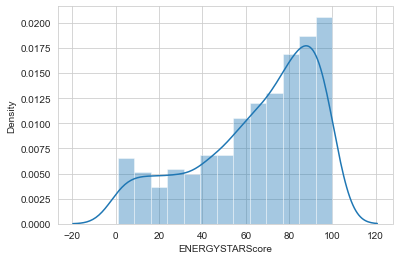

In [147]:
sns.distplot(df_exp['ENERGYSTARScore'])


In [148]:
# fill na ENERGYSTARScore avec la mediane

df_exp_med=df_exp.copy()

df_exp_med['ENERGYSTARScore'] = df_exp_med['ENERGYSTARScore'].fillna(df_exp_med['ENERGYSTARScore'].median())


#### Ce n'est pas pertinent de remplir 1/3 des valeurs par une valeur constante que ce soit la mediane ou autre. je supprime les valeurs manquantes du "EnergyStarScore"

## <font color="blue" id="section_6"> F- Export du fichier final

In [150]:
df_exp_final=df_exp.copy()
df_exp_final.shape


(1521, 16)

In [151]:
# drop na 'ENERGYSTARScore'

df_exp_final=df_exp_final.dropna()
df_exp_final.shape


(1038, 16)

In [152]:
# Enregistrer le fichier sans nan EnergyStarScore

df_exp_final.to_csv('df_final.csv', index=False)


# Enregistrer le fichier avec nan

df_exp.to_csv('df_exp.csv', index=False)